In [ ]:
%%capture
!pip install pandas
!pip install seaborn
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install cmake
!pip install scikit-learn
!pip install PyPortfolioOpt

In [ ]:
# To ignore because they have NaN values at the beginning of the evaluation
to_ignore = [
    #INCOMPLETE
    'PIRELLI & C',
    'ILLIMITY BANK',
    'AQUAFIL',
    'EQUITA GROUP',
    'ITALGAS',
    'ENAV',
    'POSTE ITALIANE',
    'GAMBERO ROSSO',
    # DELISTED
    'BORGOSESIA RSP DEAD - DELIST.28/07/21',
    'BANCA INTERMOBILIARE DEAD - DELIST.29/04/22',
    'CATTOLICA ASSICURAZIONI DEAD - DELIST.12/08/22',
    'ASTALDI DEAD - DELIST.02/08/21',
    'DEA CAPITAL DEAD - DELIST.08/03/23'
]

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as pyplot
from matplotlib.ticker import FixedLocator, FixedFormatter
import random
from scipy.stats import jarque_bera

from pypfopt import expected_returns
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.objective_functions import L2_reg
from collections import OrderedDict
from pypfopt import risk_models


In [ ]:
# Define the file path
file_path = 'sample_data/data for exam 2023.xlsx'

# Read the Excel file and select the 'stocks daily' sheet
df_stocks_daily = pd.read_excel(file_path, sheet_name='stocks daily').drop(to_ignore, axis=1)
df_stocks_monthly = pd.read_excel(file_path, sheet_name='stocks monthly').drop(to_ignore, axis=1)
df_funds_monthly = pd.read_excel(file_path, sheet_name='funds monthly')

In [ ]:
def reformat_df(df):
    # Copy dataframe
    copy = df.copy()
    # Remove the second row
    copy.drop([0,1], inplace=True)
    # Reset the index of the DataFrame
    copy.reset_index(drop=True, inplace=True)
    copy.rename(columns = {'Name':'Date'}, inplace = True)
    copy['Date'] = pd.to_datetime(copy['Date'])
    return copy.set_index('Date')

In [ ]:
def weighted_mean(numbers, weights):
  sum_of_products = 0
  sum_of_weights = 0
  for number, weight in zip(numbers, weights):
    sum_of_products += number * weight
    sum_of_weights += weight

  return sum_of_products / sum_of_weights

In [ ]:
def get_only_data(df):
    return df.iloc[:, 1:]
def get_only_date(df):
    return df.iloc[:, 0]

In [ ]:
def get_stats_concepts(df):
    return pd.DataFrame({
        'Mean': df.mean(),
        'Standard Deviation': df.std(),
        'Variance': df.var(),
        'Skewness': df.skew(),
        'Kurtosis': df.kurtosis()
    })

In [ ]:
def plot_heatmap(title, df):
    pyplot.figure(figsize=(16, 16))
    pyplot.title(title)
    #plotting the heatmap for correlation
    return sns.heatmap(df, xticklabels=True, yticklabels=True)

# 1. Focus first on the two worksheet on stocks. Compute returns for both daily and monthly stocks. Compute mean, standard deviation, variance, skewness and kurtosis for stocks at daily and monthly frequency. Show the results in a table and comment.

In [ ]:
daily = reformat_df(df_stocks_daily)
daily

LEONARDO ECOSUNTEK LANDI RENZO STELLANTIS PININFARINA FRENI BREMBO  \
Date                                                                            
2015-01-01    7.735      13.6      0.9168     4.9744      2.2126         5.54   
2015-01-02     7.73      13.6      0.9186     5.0132      2.2533        5.566   
2015-01-05     7.43      13.6      0.9219     4.9044      2.2083         5.51   
2015-01-06     7.35      13.6      0.9122     4.9822      2.2027        5.422   
2015-01-07    7.465      13.6      0.9191     5.0262      2.2196        5.364   
...             ...       ...         ...        ...         ...          ...   
2023-06-28     10.3      20.5       0.536      15.47       0.866        13.32   
2023-06-29    10.43      20.6       0.536      16.02       0.842        13.42   
2023-06-30   10.395      20.1       0.547      16.09       0.844        13.58   
2023-07-03    10.44      20.1       0.545     16.292       0.866        13.53   
2023-07-04    10.34     19.65       0.537     16.256       0.848        13.47   

           INTESA SANPAOLO UNICREDIT BANCA GENERALI BPER BANCA  ...  \
Date                                                            ...   
2015-01-01           2.422   25.1131          23.05     3.6992  ...   
2015-01-02           2.454   25.5838           23.3      3.777  ...   
2015-01-05           2.308   23.8892          22.89     3.5909  ...   
2015-01-06           2.276   23.5597          22.68     3.4555  ...   
2015-01-07           2.248    23.329          22.45     3.3776  ...   
...                    ...       ...            ...        ...  ...   
2023-06-28          2.3635     20.57          31.18      2.719  ...   
2023-06-29           2.386     21.12          31.25      2.755  ...   
2023-06-30             2.4    21.265           31.5      2.782  ...   
2023-07-03           2.437     21.49          32.09      2.813  ...   
2023-07-04          2.4205     21.13          31.64      2.742  ...   

           GABETTI PROPERTY SLTN.   MFE B    ERG CEMBRE  SABAF BEGHELLI  \
Date                                                                      
2015-01-01                 0.8245  1.9196  9.255  10.21  11.17   0.4015   
2015-01-02                  0.818  1.9151   9.41   10.4  11.17   0.3985   
2015-01-05                  0.796  1.8202   9.11  10.43  11.11    0.395   
2015-01-06                  0.796    1.77   9.09  10.59  11.05    0.391   
2015-01-07                 0.7995  1.7722  9.105  10.43  10.94    0.393   
...                           ...     ...    ...    ...    ...      ...   
2023-06-28                  0.941   0.707  26.24   29.4     14     0.26   
2023-06-29                  0.913   0.711  26.02   29.6     14     0.26   
2023-06-30                  0.913  0.7025  26.98   30.6  14.28     0.26   
2023-07-03                  0.919   0.703  27.02     30   14.4    0.255   
2023-07-04                  0.914   0.728  27.34   29.6  14.12     0.26   

              SOL DATALOGIC BIESSE SAFILO GROUP  
Date                                             
2015-01-01  6.655       8.9   9.36       6.0116  
2015-01-02  6.665      8.88   9.57       6.1009  
2015-01-05   6.73      8.84   9.96       5.9224  
2015-01-06   6.71       8.8  10.39       5.7941  
2015-01-07   6.86      8.85  10.14       5.8555  
...           ...       ...    ...          ...  
2023-06-28  26.05      6.95  11.81        1.239  
2023-06-29     26      6.92  11.83        1.255  
2023-06-30  26.45      6.95  12.06        1.242  
2023-07-03   26.4     6.895  11.88        1.245  
2023-07-04   26.3      6.94  11.76        1.195  

[2219 rows x 75 columns]

In [ ]:
monthly = reformat_df(df_stocks_monthly)
monthly

LEONARDO ECOSUNTEK LANDI RENZO STELLANTIS PININFARINA FRENI BREMBO  \
Date                                                                            
2015-01-01    7.735      13.6      0.9168     4.9744      2.2126         5.54   
2015-02-01    9.655     13.85      0.9677     6.0833      2.6003        6.254   
2015-03-01    10.83     13.89      0.9483     7.3061      2.9037         6.84   
2015-04-01    11.36     13.67      1.0557     7.8347      4.0107        7.576   
2015-05-01    11.45      11.8      1.0029     6.9175      3.5225         7.14   
...             ...       ...         ...        ...         ...          ...   
2023-03-01    10.62      19.2       0.562     17.056        0.87        14.64   
2023-04-01   10.955     19.25       0.568      16.67       0.824         13.7   
2023-05-01   10.805      18.8       0.556         15        0.82        13.31   
2023-06-01    10.33        20       0.503     14.384         0.8        14.42   
2023-07-01    10.44      20.1       0.545     16.292       0.866        13.53   

           INTESA SANPAOLO UNICREDIT BANCA GENERALI BPER BANCA  ...  \
Date                                                            ...   
2015-01-01           2.422   25.1131          23.05     3.6992  ...   
2015-02-01           2.564   24.9719           24.8     4.0985  ...   
2015-03-01           2.946   27.8903          25.21     4.8532  ...   
2015-04-01           3.202   30.1263          29.14     5.4286  ...   
2015-05-01           3.016   30.3616          29.96     5.0055  ...   
...                    ...       ...            ...        ...  ...   
2023-03-01           2.537    18.872          32.63      2.663  ...   
2023-04-01           2.365     17.93          29.34      2.293  ...   
2023-05-01          2.3845     17.94          30.09      2.545  ...   
2023-06-01            2.23    18.732          29.41      2.453  ...   
2023-07-01           2.437     21.49          32.09      2.813  ...   

           GABETTI PROPERTY SLTN.   MFE B    ERG CEMBRE  SABAF BEGHELLI  \
Date                                                                      
2015-01-01                 0.8245  1.9196  9.255  10.21  11.17   0.4015   
2015-02-01                 0.8405  2.2354  10.55  11.51   11.9    0.401   
2015-03-01                  0.893  2.3001  11.35  11.77  12.55    0.415   
2015-04-01                  1.388  2.4597  12.45  14.46  12.85    0.473   
2015-05-01                  1.177  2.5747  12.83  14.46  12.39    0.469   
...                           ...     ...    ...    ...    ...      ...   
2023-03-01                  1.156   0.666  26.66   29.4  16.78   0.2985   
2023-04-01                   1.11    0.63   27.7   30.5  16.34    0.274   
2023-05-01                   1.02   0.668   27.4   30.3   16.5     0.26   
2023-06-01                  0.779    0.65  25.76     32   15.2   0.2495   
2023-07-01                  0.919   0.703  27.02     30   14.4    0.255   

              SOL DATALOGIC BIESSE SAFILO GROUP  
Date                                             
2015-01-01  6.655       8.9   9.36       6.0116  
2015-02-01    6.8     10.13   12.7       7.1995  
2015-03-01   6.98     10.55  16.51       7.7627  
2015-04-01   8.14     10.93  15.64       8.0527  
2015-05-01    7.8     11.55   14.4       7.2608  
...           ...       ...    ...          ...  
2023-03-01  24.25     8.735  17.43        1.386  
2023-04-01     25     7.815  14.65        1.407  
2023-05-01   26.2     7.515  13.82        1.305  
2023-06-01   25.8     6.825  11.76         1.18  
2023-07-01   26.4     6.895  11.88        1.245  

[103 rows x 75 columns]

In [ ]:
# Calculate daily returns for each stock
returns_daily = get_only_data(daily).pct_change()
# Compute statistics for daily returns
daily_stats = get_stats_concepts(returns_daily)
# Calculate monthly returns for each stock
returns_monthly = get_only_data(monthly).pct_change()
# Compute statistics for monthly returns
monthly_stats = get_stats_concepts(returns_monthly)
# Create a table to display the results
table_daily_monthly_stats = pd.concat([daily_stats,monthly_stats], axis=1, keys=['Daily','Monthly'])
# Print the results
table_daily_monthly_stats

Daily                                                    \
                  Mean Standard Deviation  Variance  Skewness   Kurtosis   
ECOSUNTEK     0.000651           0.031899  0.001018  2.543398  18.734651   
LANDI RENZO   0.000224           0.030732  0.000944  1.037096  11.645041   
STELLANTIS    0.000833           0.024367  0.000594 -0.451301   5.447453   
PININFARINA   0.000271           0.035381  0.001252 -0.550217  95.226757   
FRENI BREMBO  0.000589           0.019402  0.000376  0.128630   3.770014   
...                ...                ...       ...       ...        ...   
BEGHELLI      0.000071           0.023431  0.000549  1.974864  14.328422   
SOL           0.000773           0.017558  0.000308  0.380876   1.789594   
DATALOGIC     0.000179           0.024192  0.000585  0.423539   7.429094   
BIESSE        0.000479           0.027350  0.000748 -0.150991   5.811315   
SAFILO GROUP -0.000318           0.028695  0.000823  0.432306  10.208251   

               Monthly                                                    
                  Mean Standard Deviation  Variance  Skewness   Kurtosis  
ECOSUNTEK     0.025371           0.298663  0.089199  7.564373  68.294746  
LANDI RENZO   0.006060           0.169458  0.028716  3.573282  22.042430  
STELLANTIS    0.019003           0.119976  0.014394 -0.208906   0.918015  
PININFARINA  -0.002384           0.119726  0.014334  1.101458   4.288343  
FRENI BREMBO  0.013266           0.095181  0.009060 -0.012893  -0.242610  
...                ...                ...       ...       ...        ...  
BEGHELLI     -0.000405           0.093271  0.008699  1.415495   4.329550  
SOL           0.015557           0.063613  0.004047  0.299077  -0.460985  
DATALOGIC     0.003569           0.111282  0.012384  0.273132  -0.187824  
BIESSE        0.010685           0.128054  0.016398 -0.190619   0.225876  
SAFILO GROUP -0.006264           0.137955  0.019032  1.006200   3.357589  

[74 rows x 10 columns]

In [ ]:
def get_max_min(df, column_name, sample_rate):
    sort_df = df.sort_values(column_name, ascending=False)
    name_max = sort_df.iloc[0].name
    value_max = sort_df.iloc[0][column_name]
    name_min = sort_df.iloc[-1].name
    value_min = sort_df.iloc[-1][column_name]

    print(f'MAX - {column_name:20} - {sample_rate:10}: {name_max:50} {round(value_max,5)}')
    print(f'MIN - {column_name:20} - {sample_rate:10}: {name_min:50} {round(value_min,5)}')


get_max_min(daily_stats, 'Mean', 'Daily')
get_max_min(daily_stats, 'Standard Deviation', 'Daily')
get_max_min(daily_stats, 'Variance', 'Daily')
get_max_min(daily_stats, 'Skewness', 'Daily')
get_max_min(daily_stats, 'Kurtosis', 'Daily')

get_max_min(monthly_stats, 'Mean', 'Monthly')
get_max_min(monthly_stats, 'Standard Deviation', 'Monthly')
get_max_min(monthly_stats, 'Variance', 'Monthly')
get_max_min(monthly_stats, 'Skewness', 'Monthly')
get_max_min(monthly_stats, 'Kurtosis', 'Monthly')

MAX - Mean                 - Daily     : ALERION CLEAN POWER                                0.00136
MIN - Mean                 - Daily     : CLASS EDITORI                                      -0.00068
MAX - Standard Deviation   - Daily     : VINCENZO ZUCCHI                                    0.03606
MIN - Standard Deviation   - Daily     : TERNA RETE ELETTRICA NAZ                           0.01391
MAX - Variance             - Daily     : VINCENZO ZUCCHI                                    0.0013
MIN - Variance             - Daily     : TERNA RETE ELETTRICA NAZ                           0.00019
MAX - Skewness             - Daily     : VINCENZO ZUCCHI                                    2.93824
MIN - Skewness             - Daily     : SNAM                                               -1.18956
MAX - Kurtosis             - Daily     : PININFARINA                                        95.22676
MIN - Kurtosis             - Daily     : SOL                                                1.7895

In [ ]:
def plot_histogram(df, column_name, title):
    array_filtered = df.filter(items=[column_name])[column_name].to_numpy()
    pyplot.title(title)
    ax = sns.histplot(array_filtered, kde=True)
    pyplot.xticks(np.arange(min(array_filtered), max(array_filtered), (max(array_filtered)-min(array_filtered))/20), rotation = 90)
    pyplot.show()

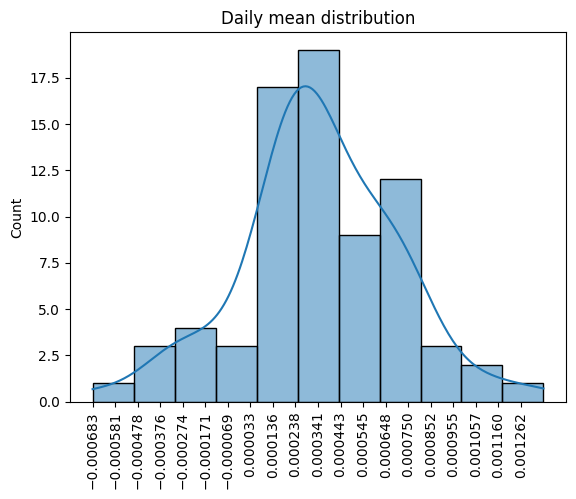

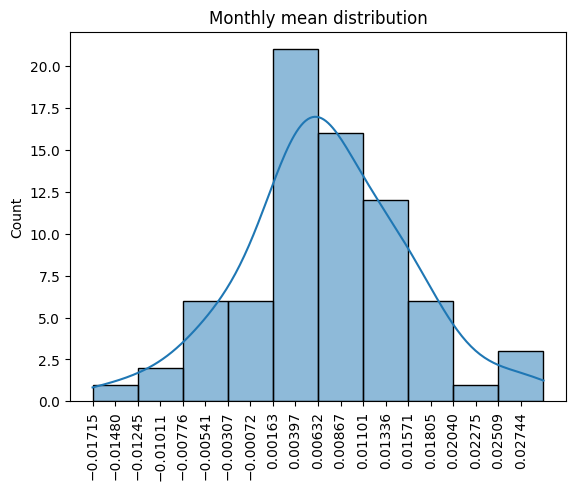

In [ ]:
plot_histogram(df=daily_stats, column_name='Mean', title='Daily mean distribution')
plot_histogram(df=monthly_stats, column_name='Mean', title='Monthly mean distribution')

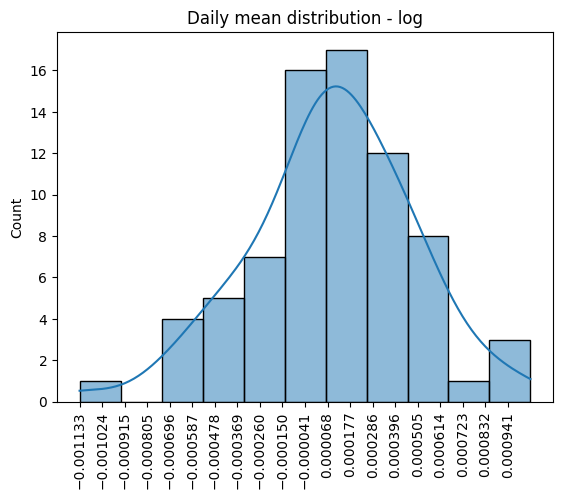

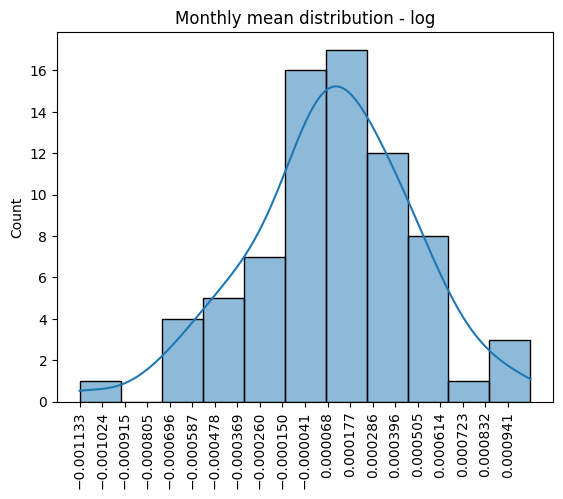

In [ ]:
# Compute statistics for log(returns+1)
daily_stats_log = get_stats_concepts(np.log(returns_daily+1))
monthly_stats_log = get_stats_concepts(np.log(returns_daily+1))
plot_histogram(df=daily_stats_log, column_name='Mean', title='Daily mean distribution - log')
plot_histogram(df=monthly_stats_log, column_name='Mean', title='Monthly mean distribution - log')

In [ ]:
for column in returns_daily.columns:
    data= returns_daily.loc[:,column].to_numpy()
    statistic,pvalue=jarque_bera(data, nan_policy='omit')
    if pvalue >= 0.05:
        print(f'{column:30} - {round(pvalue,3)}')
print('END')

END


In [ ]:
for column in returns_daily.columns:
    data= returns_daily.loc[:,column].to_numpy()
    statistic,pvalue=jarque_bera(data, nan_policy='omit')
    print(f'{column:50} - {round(pvalue,3)}')

ECOSUNTEK                                          - 0.0
LANDI RENZO                                        - 0.0
STELLANTIS                                         - 0.0
PININFARINA                                        - 0.0
FRENI BREMBO                                       - 0.0
INTESA SANPAOLO                                    - 0.0
UNICREDIT                                          - 0.0
BANCA GENERALI                                     - 0.0
BPER BANCA                                         - 0.0
FINECOBANK SPA                                     - 0.0
DAVIDE CAMPARI MILANO                              - 0.0
CALTAGIRONE                                        - 0.0
ENEL                                               - 0.0
ALERION CLEAN POWER                                - 0.0
A2A                                                - 0.0
TERNA RETE ELETTRICA NAZ                           - 0.0
ACEA                                               - 0.0
BANCA MEDIOLANUM               

In [ ]:
for column in returns_monthly.columns:
    data= returns_monthly.loc[:,column].to_numpy()
    statistic,pvalue=jarque_bera(data, nan_policy='omit')
    if pvalue >= 0.05:
        print(f'{column:30}  {round(pvalue,3)}')
print('END')

STELLANTIS                      0.17
FRENI BREMBO                    0.836
BPER BANCA                      0.191
FINECOBANK SPA                  0.935
DAVIDE CAMPARI MILANO           0.206
CALTAGIRONE                     0.249
ENEL                            0.328
TERNA RETE ELETTRICA NAZ        0.531
ACEA                            0.505
TAMBURI INV.PARTNERS            0.888
ANIMA HOLDING                   0.244
ENERVIT                         0.222
IREN                            0.066
EL EN                           0.748
DE LONGHI                       0.958
INTERPUMP GROUP                 0.084
CAIRO COMMUNICATION             0.239
SNAM                            0.421
RECORDATI INDUA.CHIMICA         0.282
BRIOSCHI SVILUPPO IMMBL         0.069
UNIPOLSAI                       0.311
BUZZI                           0.686
DANIELI                         0.375
SABAF                           0.673
SOL                             0.283
DATALOGIC                       0.48
BIESSE        

In [ ]:
for column in returns_monthly.columns:
    data= returns_monthly.loc[:,column].to_numpy()
    statistic,pvalue=jarque_bera(data, nan_policy='omit')
    print(f'{column:50} - {round(pvalue,3)}')

ECOSUNTEK                                          - 0.0
LANDI RENZO                                        - 0.0
STELLANTIS                                         - 0.17
PININFARINA                                        - 0.0
FRENI BREMBO                                       - 0.836
INTESA SANPAOLO                                    - 0.0
UNICREDIT                                          - 0.003
BANCA GENERALI                                     - 0.007
BPER BANCA                                         - 0.191
FINECOBANK SPA                                     - 0.935
DAVIDE CAMPARI MILANO                              - 0.206
CALTAGIRONE                                        - 0.249
ENEL                                               - 0.328
ALERION CLEAN POWER                                - 0.0
A2A                                                - 0.0
TERNA RETE ELETTRICA NAZ                           - 0.531
ACEA                                               - 0.505
BANCA MEDI

# 2. Compute the variance-covariance matrix and the correlation matrix.'

In [ ]:
daily_without_ignore_columns = returns_daily.copy()
monthly_without_ignore_columns = returns_monthly.copy()
daily_variance_covariance = daily_without_ignore_columns.astype(float).cov()
monthly_variance_covariance = monthly_without_ignore_columns.astype(float).cov()
daily_correlation = daily_without_ignore_columns.astype(float).corr()
monthly_correlation = monthly_without_ignore_columns.astype(float).corr()

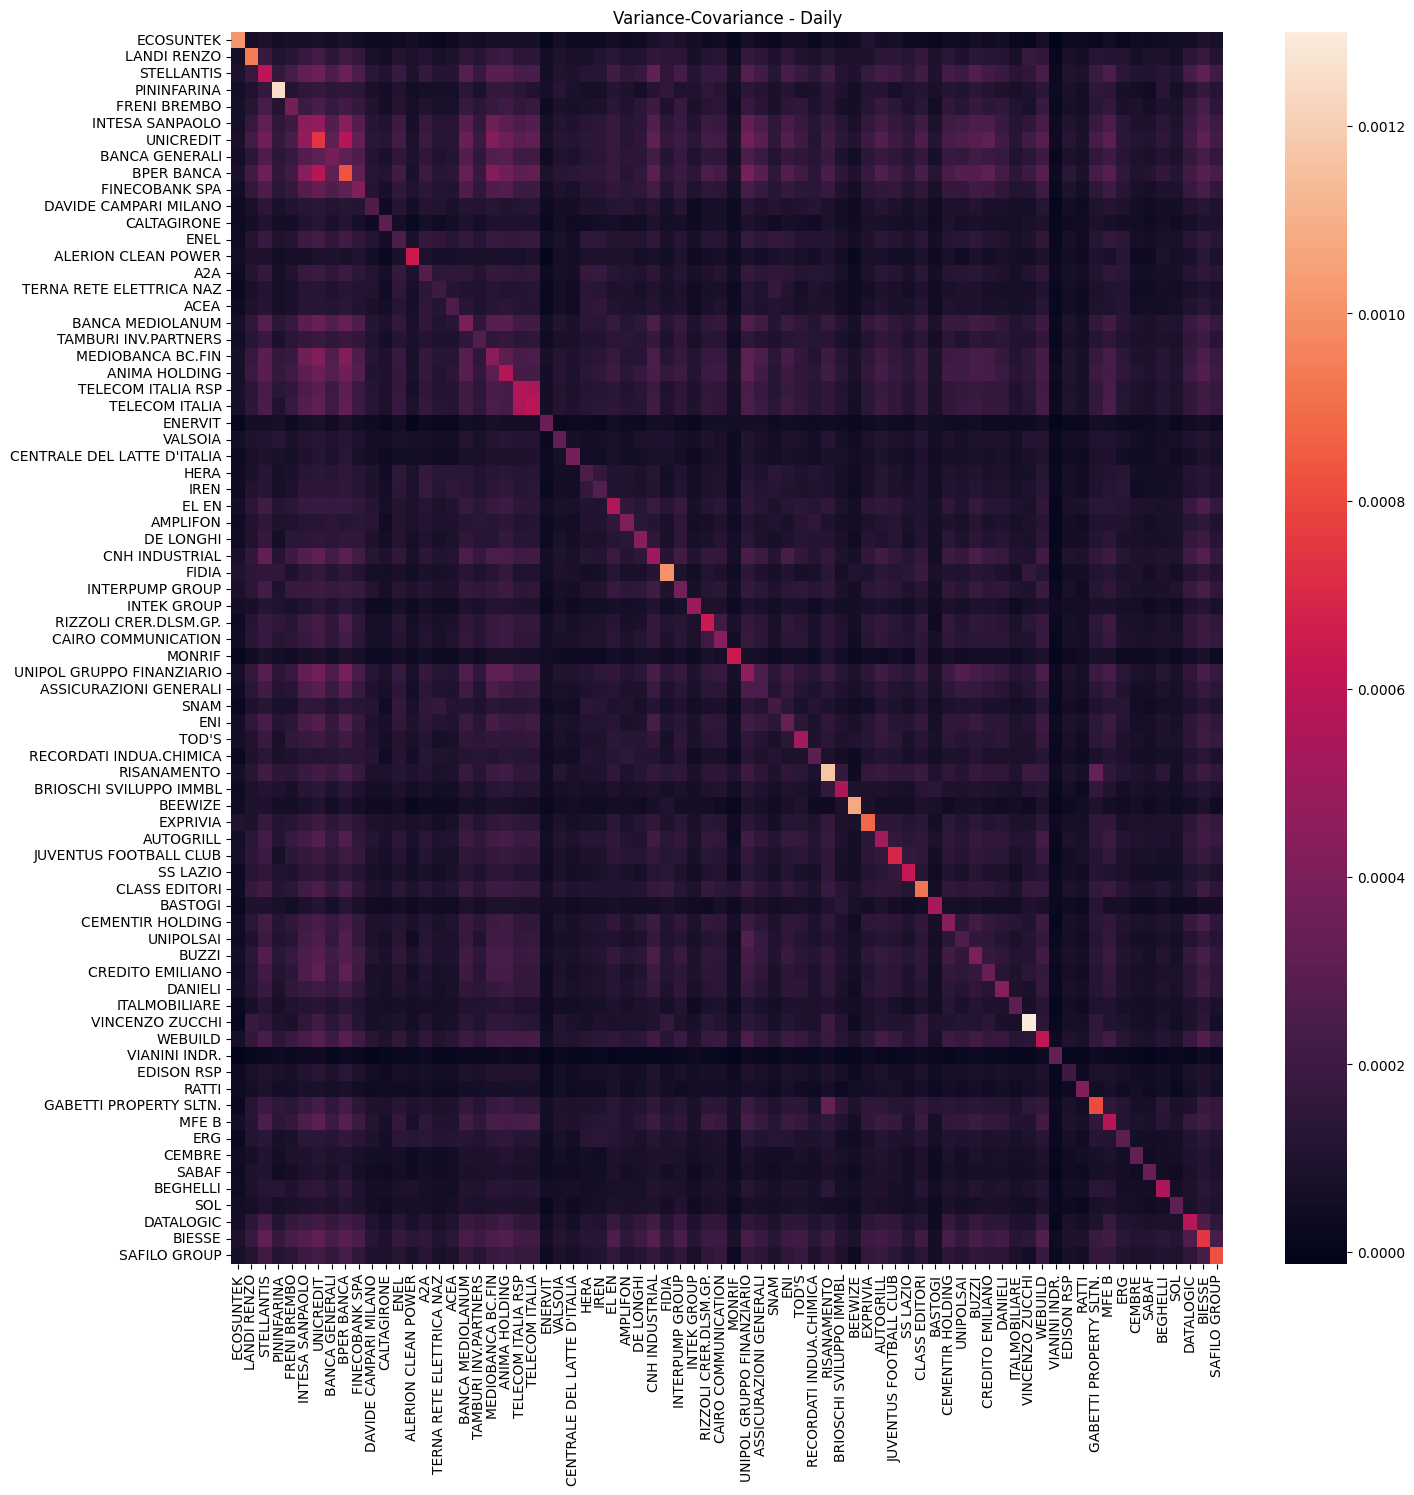

In [ ]:
ax = plot_heatmap(title='Variance-Covariance - Daily', df=daily_variance_covariance)

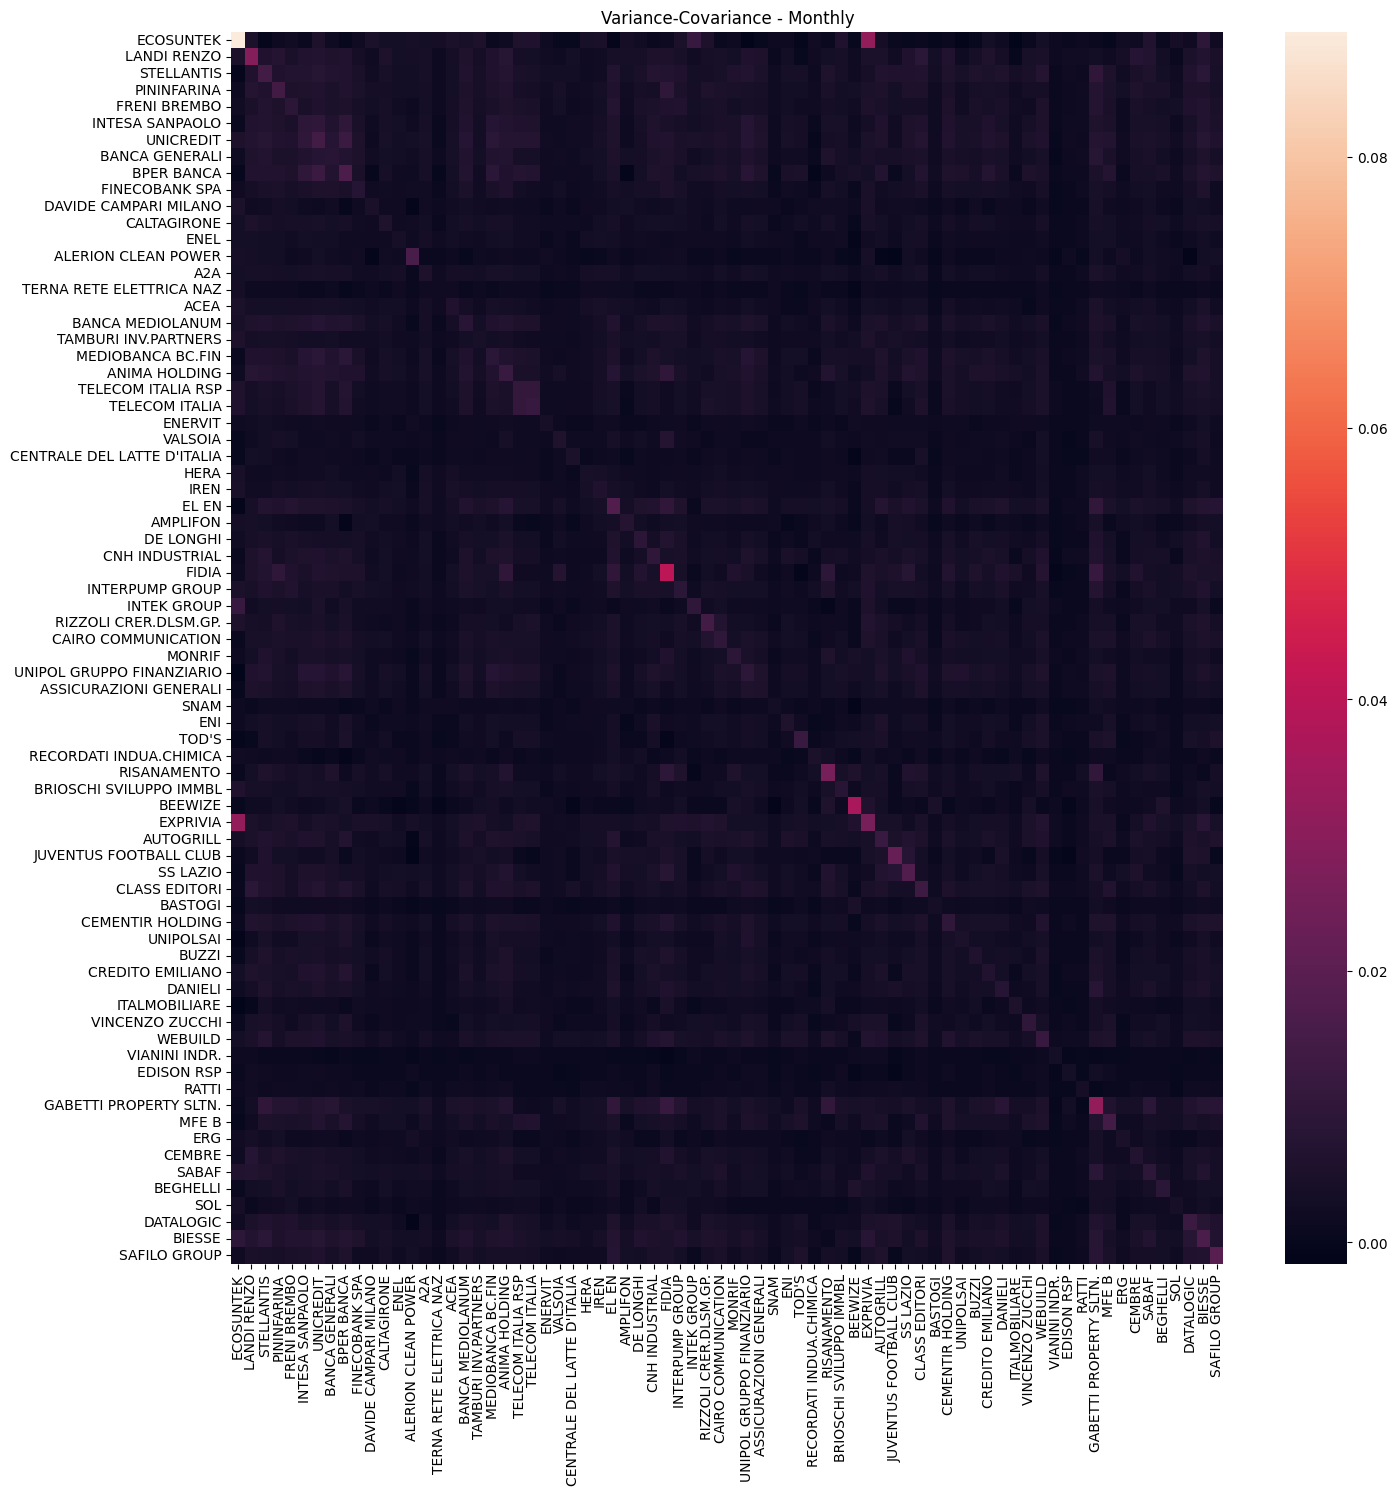

In [ ]:
ax = plot_heatmap(title='Variance-Covariance - Monthly', df=monthly_variance_covariance)

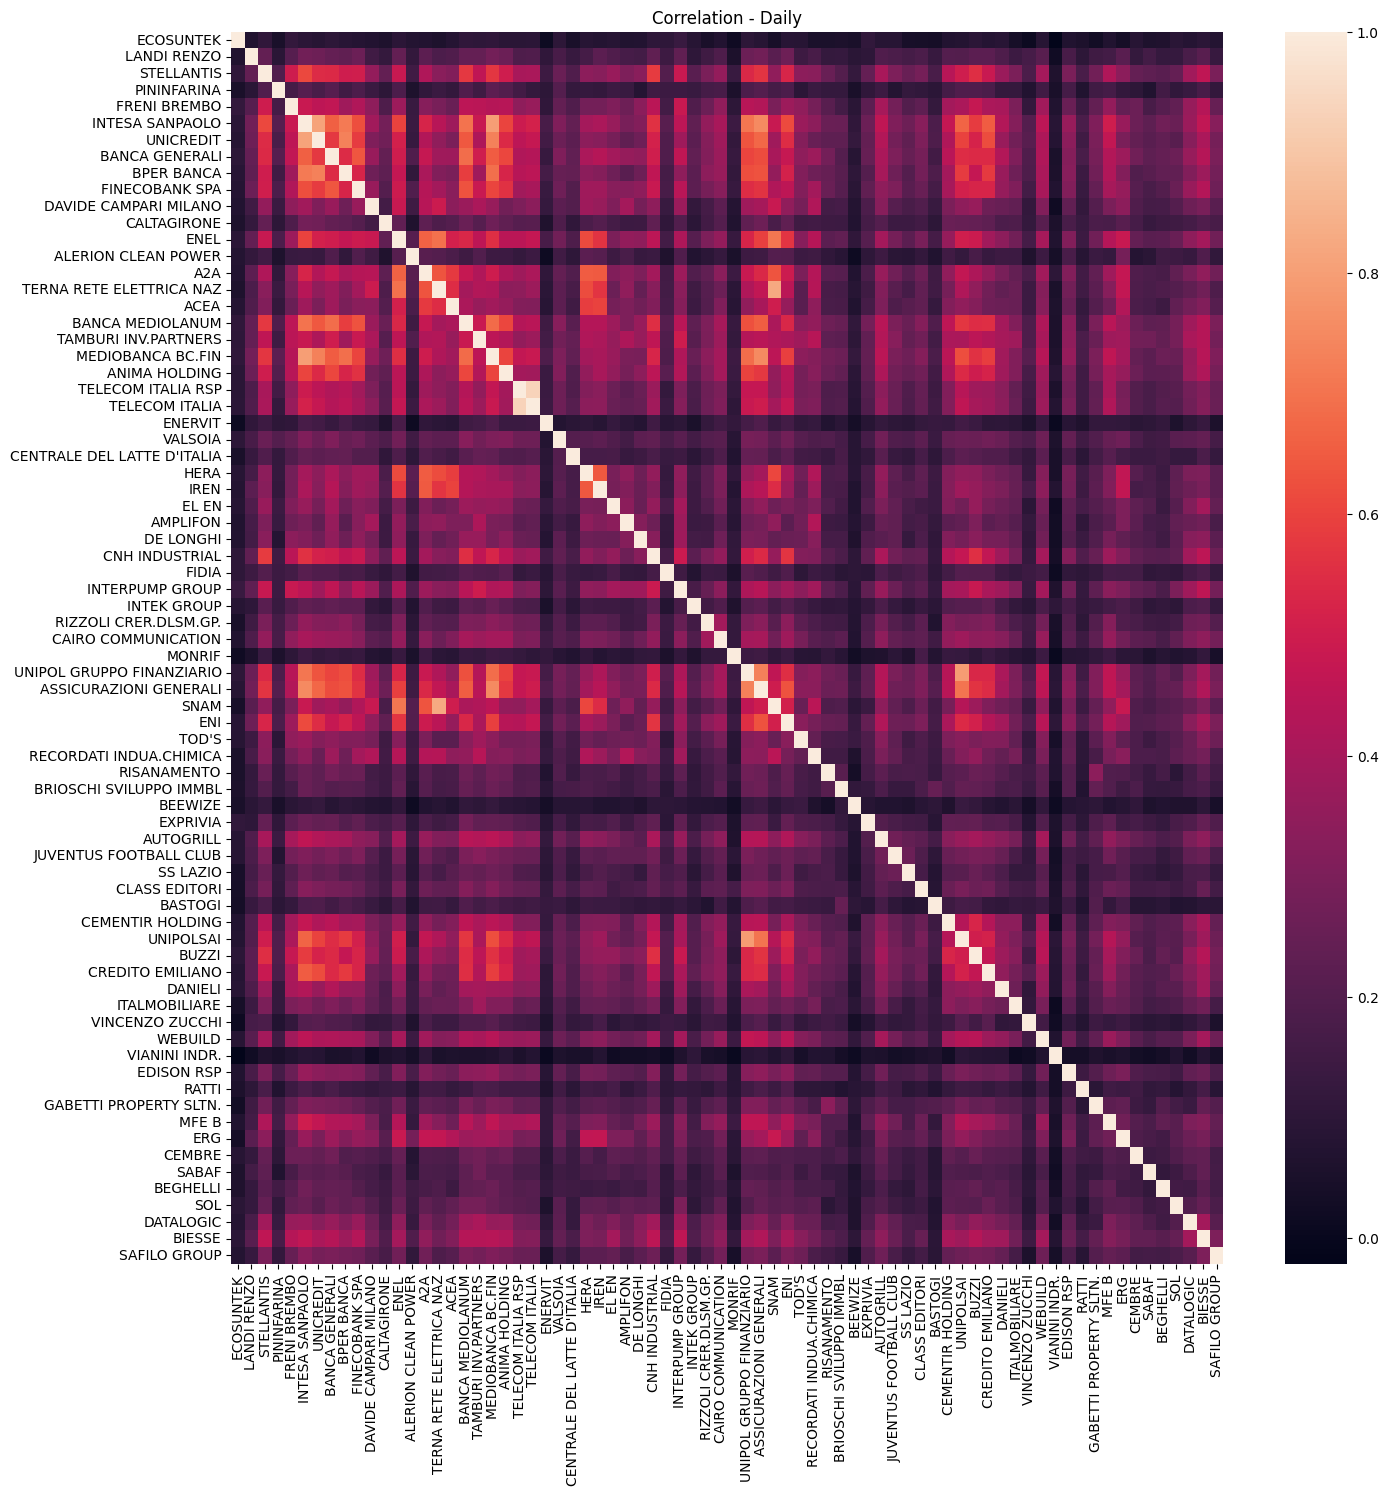

In [ ]:
ax = plot_heatmap(title='Correlation - Daily', df=daily_correlation)

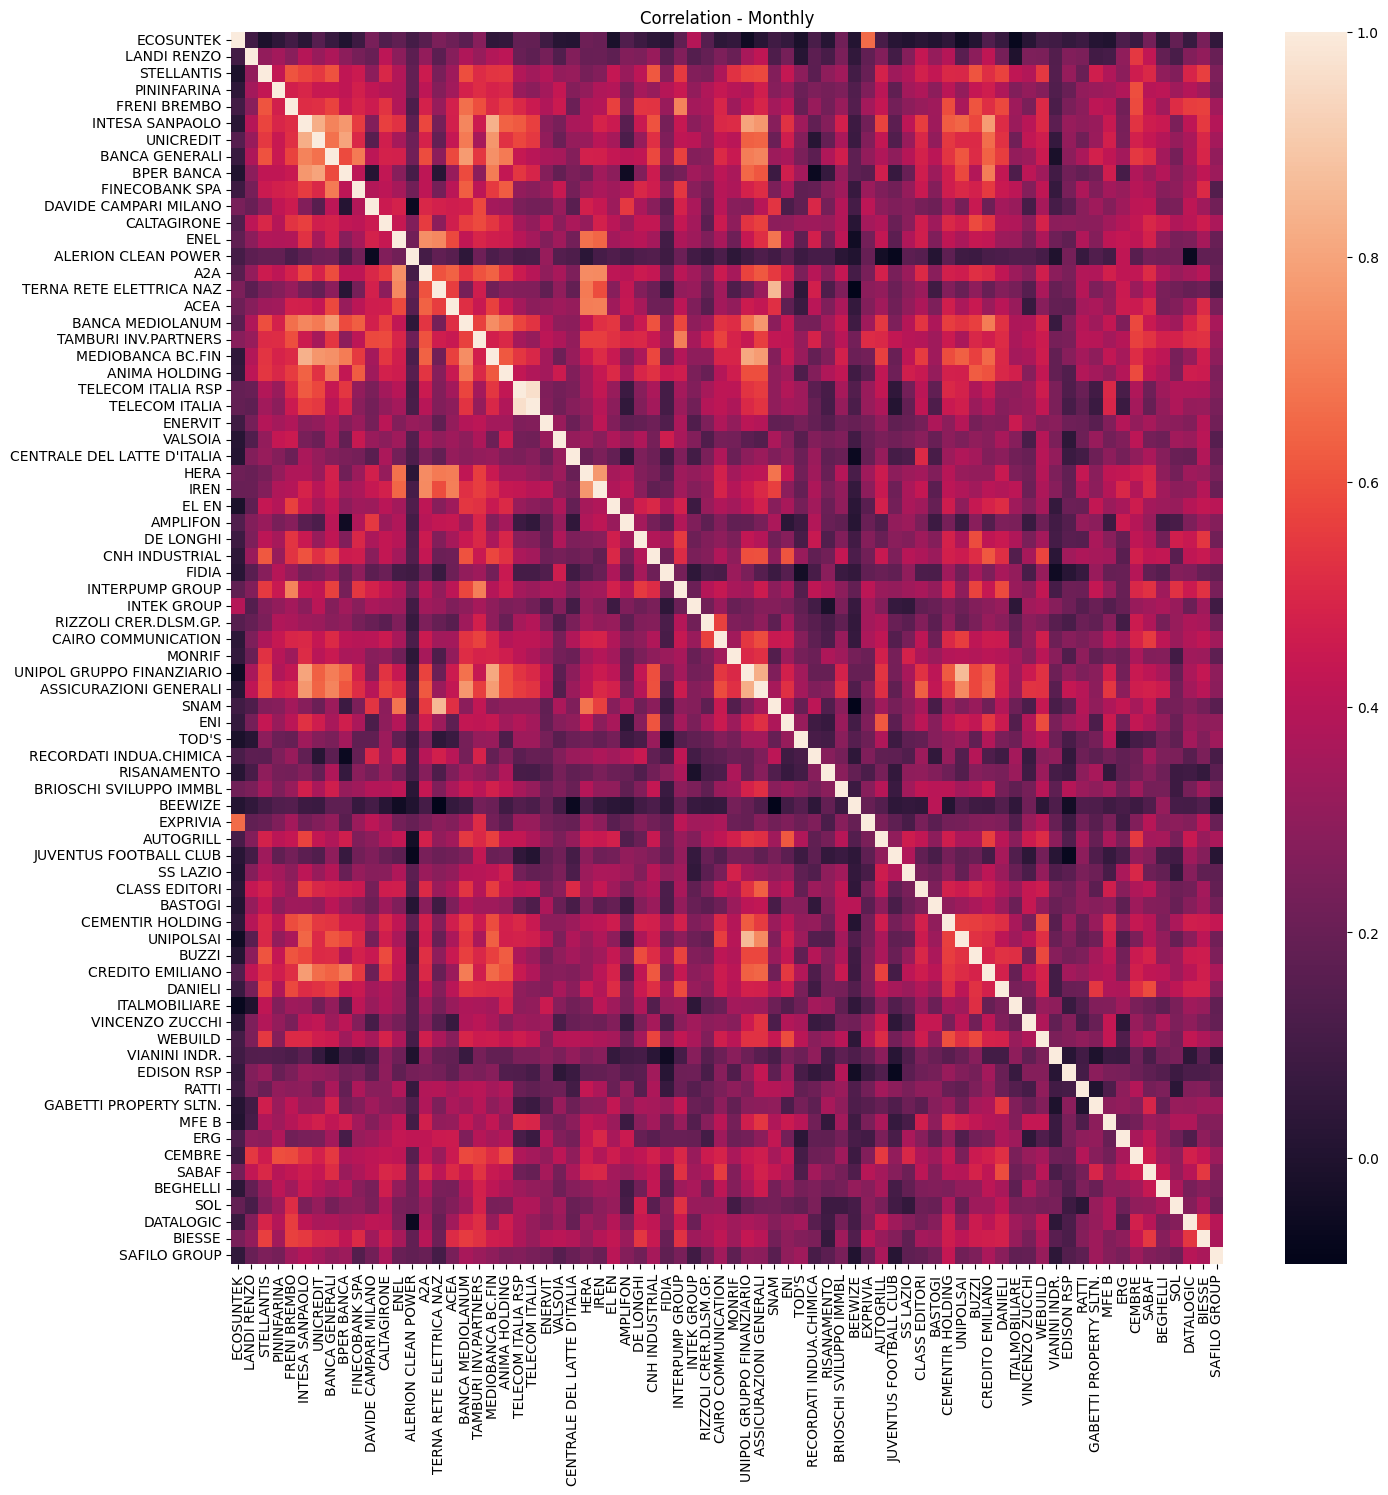

In [ ]:
ax = plot_heatmap(title='Correlation - Monthly', df=monthly_correlation)

In [ ]:
def get_less_correlated_pair_stocks(correlation_matrix):
    matrix_correlation_returns_sorted = convert_upper_diagonal_to_nan(correlation_matrix.copy()).unstack().sort_values().to_frame().reset_index()
    selected_columns = []
    for index, row in matrix_correlation_returns_sorted.iterrows():
        if row['level_0'] not in selected_columns:
            selected_columns.append(row['level_0'])
            if len(selected_columns) == 20:
                break
        if row['level_1'] not in selected_columns:
            selected_columns.append(row['level_1'])
            if len(selected_columns) == 20:
                break
    return selected_columns


def get_colleration_pair_stocks(correlation_matrix_stacked, stock_name_1, stock_name_2):
    return correlation_matrix_stacked.loc[(correlation_matrix_stacked['level_0'] == stock_name_1) & (correlation_matrix_stacked['level_1'] == stock_name_2)].iloc[0, 2]

def get_less_correlated_pair_stocks_new(correlation_matrix, preselected_stocks = [], n_stock_to_select = 10):
    matrix_correlation_returns_sorted = correlation_matrix.copy().unstack().sort_values().to_frame().dropna().reset_index()

    for threshold_base in range(1, 200):
        threshold = threshold_base/100
        stocks_ordered_by_correlation = []

        for index, row in matrix_correlation_returns_sorted.iterrows():
            stocks_ordered_by_correlation.append(row['level_0'])
            stocks_ordered_by_correlation.append(row['level_1'])


        stocks_ordered_by_correlation = list(dict.fromkeys(stocks_ordered_by_correlation))
        selected_columns = preselected_stocks
        for stock in stocks_ordered_by_correlation:
            if len(selected_columns) == n_stock_to_select:
                print(f'Threshold: {threshold}')
                print(f'Total stocks: {len(selected_columns)}')
                return selected_columns


            if stock in selected_columns:
                continue

            count = len(selected_columns)
            for already_selected_stock in selected_columns:
                if get_colleration_pair_stocks(matrix_correlation_returns_sorted, stock_name_1=stock, stock_name_2=already_selected_stock) < threshold:
                    count -= 1

            if count == 0:
                selected_columns.append(stock)

In [ ]:
n_stock = 10

In [ ]:
less_correlated_pair_stocks_daily_new = get_less_correlated_pair_stocks_new(daily_correlation, preselected_stocks = [], n_stock_to_select = n_stock)
less_correlated_pair_stocks_daily_new

Threshold: 0.12
Total stocks: 10


['VIANINI INDR.',
 'ECOSUNTEK',
 'MONRIF',
 'BEEWIZE',
 'PININFARINA',
 'VINCENZO ZUCCHI',
 'ALERION CLEAN POWER',
 'RATTI',
 'ENERVIT',
 'SABAF']

### Average daily returns of daily selected

In [ ]:
pd.DataFrame(daily, columns = less_correlated_pair_stocks_daily_new).pct_change().mean().mean()*100

0.031995096604848484

### Average monthly returns of daily selected

In [ ]:
pd.DataFrame(monthly, columns = less_correlated_pair_stocks_daily_new).pct_change().mean().mean()*100

0.5583289881202267

In [ ]:
less_correlated_pair_stocks_monthly_new =  get_less_correlated_pair_stocks_new(monthly_correlation, preselected_stocks = [], n_stock_to_select = n_stock)
less_correlated_pair_stocks_monthly_new

Threshold: 0.24
Total stocks: 10


['SNAM',
 'BEEWIZE',
 'FIDIA',
 'ALERION CLEAN POWER',
 'ECOSUNTEK',
 'VIANINI INDR.',
 'LANDI RENZO',
 'RIZZOLI CRER.DLSM.GP.',
 "TOD'S",
 'JUVENTUS FOOTBALL CLUB']

### Average daily returns of monthly selected

In [ ]:
pd.DataFrame(daily, columns = less_correlated_pair_stocks_monthly_new).pct_change().mean().mean()*100

0.03871993527545127

### Average monthly returns of monthly selected

In [ ]:
pd.DataFrame(monthly, columns = less_correlated_pair_stocks_monthly_new).pct_change().mean().mean()*100

0.9915902837776455

# 3. Select a sample made of 10-12 securities. You should motivate your choice of securities. The choice can be made, for example, on the basis of the correlation structure of the variance-covariance matrix. Explain and justify your choices.

In [ ]:
def plot_stocks(df, title, columns):
    ax = df.plot(figsize=(10, 8))
    ax.grid(which = "major", linewidth = 1, alpha=0.3)
    ax.grid(which = "minor", linewidth = 0.2, alpha=0.3)
    ax.minorticks_on()
    ax.set_title(title,color='black')
    ax.set_xlabel('Date')
    ax.set_ylabel('Amount (€)')

    ax.legend(bbox_to_anchor=(1.0, 1.0), frameon=False)

    # Modify y-axis tick labels with symbol
    ticks = ax.get_yticks()
    labels = [f'€{tick}' for tick in ticks]

    # Set modified labels and fixed locator on the y-axis
    ax.yaxis.set_major_locator(FixedLocator(ticks))
    ax.yaxis.set_major_formatter(FixedFormatter(labels))

In [ ]:
# get random stock columns
samples = 10
columns = [col for col in daily.columns if col != 'Date']
selected_columns = less_correlated_pair_stocks_monthly_new

In [ ]:
# select random stock
selected_daily = daily.filter(items=selected_columns)
selected_monthly = monthly.filter(items=selected_columns)

# 4. Plot the behavior of the security prices you have chosen, both in daily and monthly frequency during the entire lenght of the sample size.

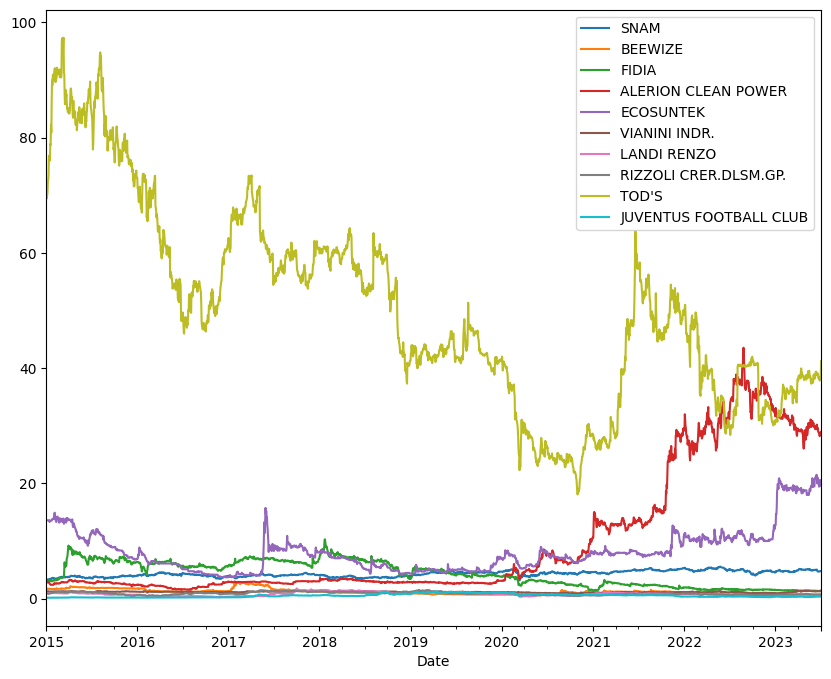

In [ ]:
ax = selected_daily.plot(figsize=(10, 8))

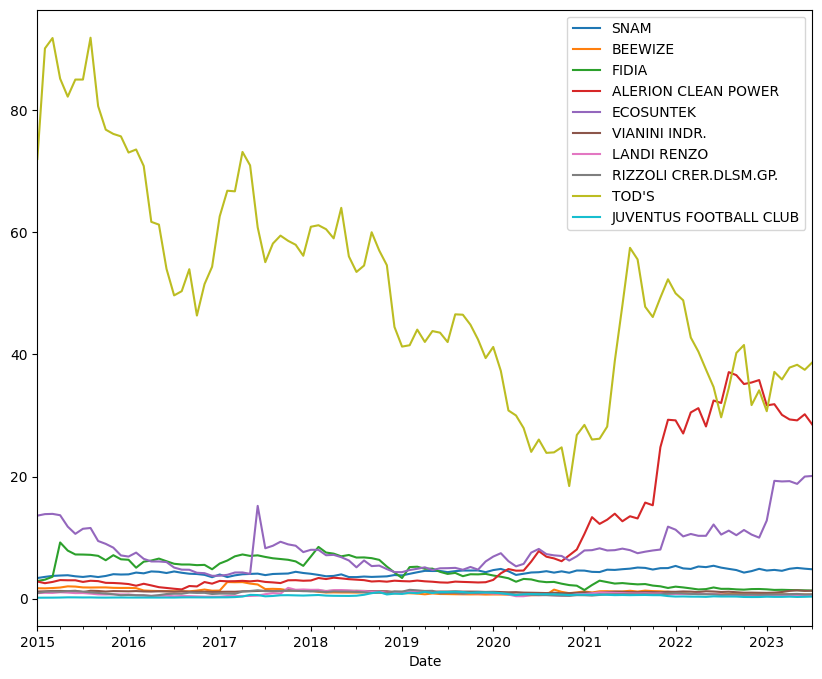

In [ ]:
ax = selected_monthly.plot(figsize=(10, 8))

# 5. Compute the Mean Variance optimal portfolio allocation for the sample of securities chosen by you both in daily and monthly frequency. Discuss.

In [ ]:
def plot_weights(weights, title):
    # Plotting the values
    x = np.array(list(weights.keys()))
    y = np.array(list(weights.values()))*100

    ax = pyplot.bar(x, y)
    pyplot.suptitle(title, fontsize=12)

    pyplot.ylabel('Weights')
    pyplot.xticks(rotation=30, ha='right')

    for i in range(len(x)):
        pyplot.text(i,y[i] // 2,f"{round(y[i],2)} %", ha = 'center',
                     bbox = dict(facecolor = 'white'))

    pyplot.show()

def plot_weights_arr(weights_arr = [], title_arr = []):
    num_plots = len(weights_arr)
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots / num_rows))

    fig, axes = pyplot.subplots(num_rows, num_cols, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(num_plots):
        axes[i].set_title(title_arr[i])
        axes[i].set_ylabel('Weights')

        keys = list(weights_arr[i].keys())
        values = np.array(list(weights_arr[i].values())) * 100

        bars = axes[i].bar(keys, values)
        axes[i].set_xticks(axes[i].get_xticks(),axes[i].get_xticklabels(), rotation=45, ha='right')

        for bar in bars:
            height = bar.get_height()
            axes[i].annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height // 2),
                             xytext=(0, 3), textcoords='offset points',
                             ha='center', va='bottom', bbox = dict(facecolor = 'white'), fontsize=8)

    # Remove any extra empty subplots
    if num_plots < len(axes):
        for j in range(num_plots, len(axes)):
            fig.delaxes(axes[j])

    pyplot.tight_layout()
    pyplot.show()

In [ ]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.risk_models import sample_cov

def get_mu_s(prices, stocks_names, frequency):
    mu = mean_historical_return(prices.filter(items=stocks_names), frequency=frequency)
    S = sample_cov(prices.filter(items=stocks_names), frequency=frequency)
    return (mu, S)

In [ ]:
def get_efficient_frontier(mu,s,allow_short_selling):
    weight_bounds = (0,1)
    if allow_short_selling is True:
        weight_bounds = (-1,1)
    else:
        weight_bounds = (0,1)
    return EfficientFrontier(mu, s , weight_bounds=weight_bounds)

In [ ]:
def portfolio_weighted(portfolio_returns, df_returns, df_weights):
    for col in df_returns.columns:
        for i in range(0,len(df_returns)):
            df_returns.iloc[i][col] = portfolio_returns.iloc[i][col]*df_weights.loc[col]["Weight"]
    return(df_returns)

## MONTHLY

In [ ]:
portfolio_monthly_avg_returns = expected_returns.mean_historical_return(selected_monthly)
portfolio_monthly_avg_returns.round(4)

SNAM                        1.3936
BEEWIZE                    -0.9011
FIDIA                      -0.8535
ALERION CLEAN POWER       303.4146
ECOSUNTEK                   1.6251
VIANINI INDR.               0.2946
LANDI RENZO                -0.7233
RIZZOLI CRER.DLSM.GP.      -0.4567
TOD'S                      -0.7843
JUVENTUS FOOTBALL CLUB      5.7326
dtype: float64

In [ ]:
portfolio_monthly_cov_mat = risk_models.sample_cov(selected_monthly)
portfolio_monthly_cov_mat.round(4)

SNAM  BEEWIZE    FIDIA  ALERION CLEAN POWER  \
SNAM                    0.6783  -0.2337   0.2102               0.1614   
BEEWIZE                -0.2337   9.0911   0.5076               0.0190   
FIDIA                   0.2102   0.5076  10.2196               0.5659   
ALERION CLEAN POWER     0.1614   0.0190   0.5659               4.0377   
ECOSUNTEK               0.3578   0.1332   0.3595               0.9922   
VIANINI INDR.           0.0846   0.3428  -0.1351              -0.0055   
LANDI RENZO             0.2841   0.4132   1.3786               0.9094   
RIZZOLI CRER.DLSM.GP.   0.2766   0.3186   0.7341               0.2501   
TOD'S                   0.2810   0.7969  -0.2132               0.2849   
JUVENTUS FOOTBALL CLUB  0.4642   0.2938   1.3615              -0.3469   

                        ECOSUNTEK  VIANINI INDR.  LANDI RENZO  \
SNAM                       0.3578         0.0846       0.2841   
BEEWIZE                    0.1332         0.3428       0.4132   
FIDIA                      0.3595        -0.1351       1.3786   
ALERION CLEAN POWER        0.9922        -0.0055       0.9094   
ECOSUNTEK                 22.4783         0.3862       1.2270   
VIANINI INDR.              0.3862         0.7699       0.3378   
LANDI RENZO                1.2270         0.3378       7.2364   
RIZZOLI CRER.DLSM.GP.      1.3741         0.2612       0.9760   
TOD'S                     -0.1190         0.3230       0.0839   
JUVENTUS FOOTBALL CLUB     0.2816         0.0500       0.6463   

                        RIZZOLI CRER.DLSM.GP.   TOD'S  JUVENTUS FOOTBALL CLUB  
SNAM                                   0.2766  0.2810                  0.4642  
BEEWIZE                                0.3186  0.7969                  0.2938  
FIDIA                                  0.7341 -0.2132                  1.3615  
ALERION CLEAN POWER                    0.2501  0.2849                 -0.3469  
ECOSUNTEK                              1.3741 -0.1190                  0.2816  
VIANINI INDR.                          0.2612  0.3230                  0.0500  
LANDI RENZO                            0.9760  0.0839                  0.6463  
RIZZOLI CRER.DLSM.GP.                  3.6827  0.6635                  0.9122  
TOD'S                                  0.6635  3.0708                  0.3522  
JUVENTUS FOOTBALL CLUB                 0.9122  0.3522                  5.6300

In [ ]:
portfolio_monthly_returns = returns_monthly.filter(items=selected_columns)
mu_monthly = portfolio_monthly_returns.mean()
sigma_monthly = portfolio_monthly_returns.cov()

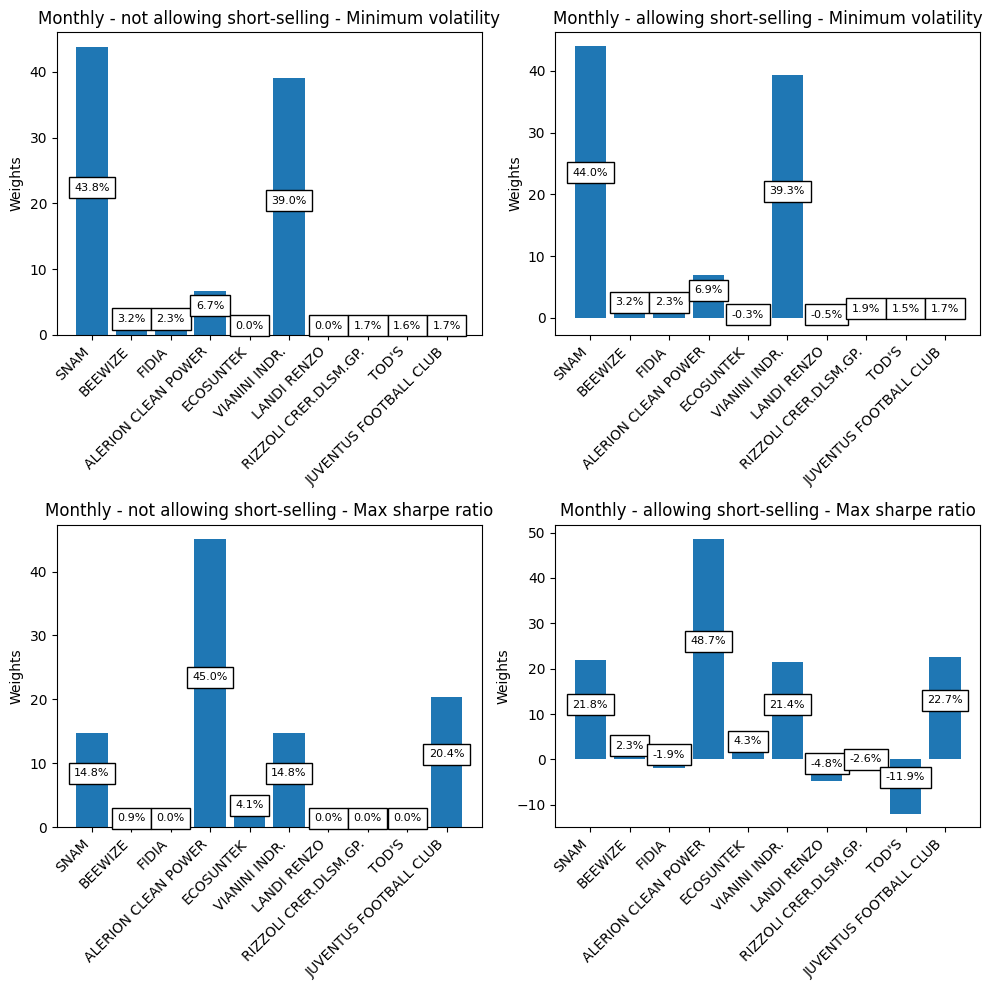

In [ ]:
# Portfolio Optimization - Monthly data:  minimum volatility (non-negative)
ef_min_volatility_monthly = EfficientFrontier(mu_monthly, sigma_monthly, weight_bounds=(0, 1))
weights_min_volatility_monthly = ef_min_volatility_monthly.min_volatility()
cleaned_weights_min_volatility_monthly = pd.DataFrame(ef_min_volatility_monthly.clean_weights().values(),
                                        index = portfolio_monthly_returns.columns, columns=["Weight"])

# Portfolio Optimization - Monthly data:  minimum volatility
ef_min_volatility_shorting_monthly = EfficientFrontier(mu_monthly, sigma_monthly, weight_bounds=(-1, 1))
weights_min_volatility_shorting_monthly = ef_min_volatility_shorting_monthly.min_volatility()
cleaned_weights_min_volatility_shorting_monthly = pd.DataFrame(ef_min_volatility_shorting_monthly.clean_weights().values(),
                                         index = portfolio_monthly_returns.columns, columns=["Weight"])

# Portfolio Optimization - Monthly data:  maximal Sharpe ratio (a.k.a the tangency portfolio, non-negative)
ef_max_sharpe_ratio_monthly = EfficientFrontier(mu_monthly, sigma_monthly, weight_bounds=(0, 1))
weights_max_sharpe_ratio_monthly = ef_max_sharpe_ratio_monthly.max_sharpe(risk_free_rate=0)
cleaned_weights_max_sharpe_ratio_monthly = pd.DataFrame(ef_max_sharpe_ratio_monthly.clean_weights().values(),
                                        index = portfolio_monthly_returns.columns, columns=["Weight"])

# Portfolio Optimization - Monthly data:  maximal Sharpe ratio (a.k.a the tangency portfolio)
ef_max_sharpe_ratio_shorting_monthly = EfficientFrontier(mu_monthly, sigma_monthly, weight_bounds=(-1, 1))
weights_max_sharpe_ratio_shorting_monthly = ef_max_sharpe_ratio_shorting_monthly.max_sharpe(risk_free_rate=0)
cleaned_weights_max_sharpe_ratio_shorting_monthly = pd.DataFrame(ef_max_sharpe_ratio_shorting_monthly.clean_weights().values(),
                                         index = portfolio_monthly_returns.columns, columns=["Weight"])


plot_weights_arr(
    weights_arr=[
        weights_min_volatility_monthly,
        weights_min_volatility_shorting_monthly,
        weights_max_sharpe_ratio_monthly,
        weights_max_sharpe_ratio_shorting_monthly
        ],
    title_arr=[
        'Monthly - not allowing short-selling - Minimum volatility',
        'Monthly - allowing short-selling - Minimum volatility',
        'Monthly - not allowing short-selling - Max sharpe ratio',
        'Monthly - allowing short-selling - Max sharpe ratio',
        ]
)


In [ ]:
# Portfolio Monthly - not allowing short-selling - Minimum volatility
portfolio_monthly_returns_min_volatility = pd.DataFrame(index = portfolio_monthly_returns.index,
                                          columns = portfolio_monthly_returns.columns)
portfolio_monthly_returns_min_volatility = portfolio_weighted(portfolio_monthly_returns, portfolio_monthly_returns_min_volatility, cleaned_weights_min_volatility_monthly)


# Portfolio Monthly - allowing short-selling - Minimum volatility
portfolio_monthly_returns_min_volatility_shorting = pd.DataFrame(index = portfolio_monthly_returns.index,
                                           columns = portfolio_monthly_returns.columns)
portfolio_monthly_returns_min_volatility_shorting = portfolio_weighted(portfolio_monthly_returns, portfolio_monthly_returns_min_volatility_shorting, cleaned_weights_min_volatility_shorting_monthly)


# Portfolio Monthly - not allowing short-selling - Max sharpe ratio
portfolio_monthly_returns_max_sharpe_ratio = pd.DataFrame(index = portfolio_monthly_returns.index,
                                           columns = portfolio_monthly_returns.columns)
portfolio_monthly_returns_max_sharpe_ratio = portfolio_weighted(portfolio_monthly_returns, portfolio_monthly_returns_max_sharpe_ratio, cleaned_weights_max_sharpe_ratio_monthly)


# Portfolio Monthly - allowing short-selling - Max sharpe ratio
portfolio_monthly_returns_max_sharpe_ratio_shorting = pd.DataFrame(index = portfolio_monthly_returns.index,
                                           columns = portfolio_monthly_returns.columns)
portfolio_monthly_returns_max_sharpe_ratio_shorting = portfolio_weighted(portfolio_monthly_returns, portfolio_monthly_returns_max_sharpe_ratio_shorting, cleaned_weights_max_sharpe_ratio_shorting_monthly)

In [ ]:
np.random.seed(42)
init_ret = portfolio_monthly_returns
num_ports = 3000 # number of portfolios
all_weights = np.zeros((num_ports, len(init_ret.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(init_ret.columns)))
    weights = weights/np.sum(weights)

    # Save weights
    all_weights[x,:] = weights

    # Expected return
    ret_arr[x] = np.sum( (init_ret.mean() * weights))

    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(init_ret.cov(), weights)))

    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [ ]:
ef_max_sharpe_ratio_shorting_monthly.portfolio_performance()

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.02079706604276143, 0.0719720576615718, 0.2889602815102736)

In [ ]:
portfolio_monthly_returns_max_sharpe_ratio_shorting.mean().mean()

0.002079710202984134

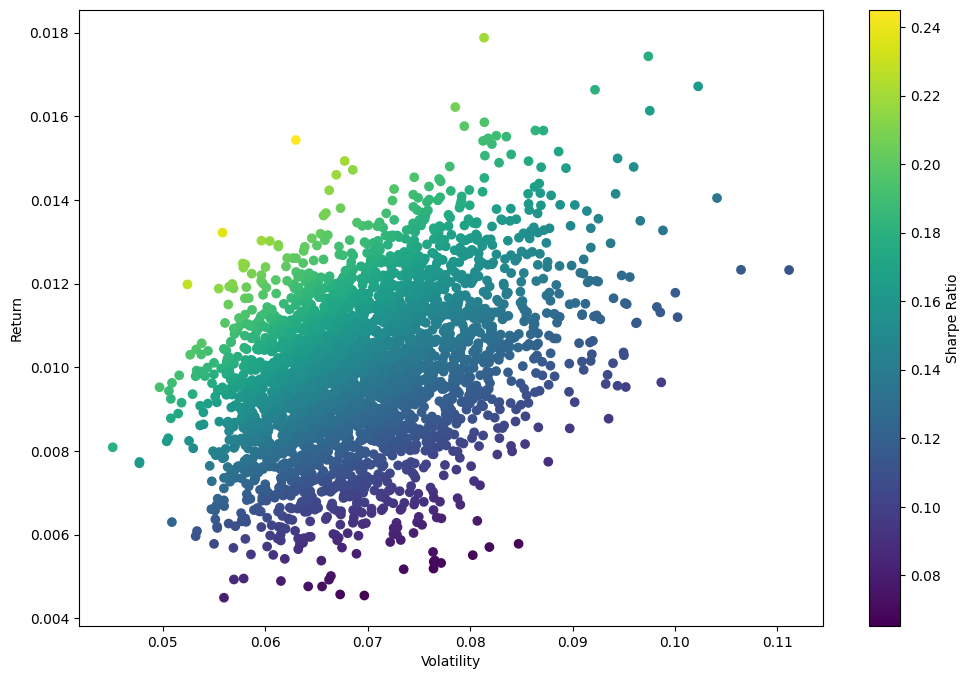

In [ ]:
pyplot.figure(figsize=(12,8))
pyplot.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
pyplot.colorbar(label='Sharpe Ratio')
pyplot.xlabel('Volatility')
pyplot.ylabel('Return')
pyplot.show()

## DAILY


In [ ]:
portfolio_daily_avg_returns = expected_returns.mean_historical_return(selected_daily)
portfolio_daily_avg_returns.round(4)

SNAM                      0.0398
BEEWIZE                  -0.1009
FIDIA                    -0.0799
ALERION CLEAN POWER       0.3031
ECOSUNTEK                 0.0427
VIANINI INDR.             0.0119
LANDI RENZO              -0.0590
RIZZOLI CRER.DLSM.GP.    -0.0277
TOD'S                    -0.0614
JUVENTUS FOOTBALL CLUB    0.0955
dtype: float64

In [ ]:
portfolio_daily_cov_mat = risk_models.sample_cov(selected_daily)
portfolio_daily_cov_mat.round(4)

SNAM  BEEWIZE   FIDIA  ALERION CLEAN POWER  \
SNAM                    0.0542   0.0119  0.0177               0.0190   
BEEWIZE                 0.0119   0.2709  0.0266               0.0038   
FIDIA                   0.0177   0.0266  0.2535               0.0132   
ALERION CLEAN POWER     0.0190   0.0038  0.0132               0.1619   
ECOSUNTEK               0.0055   0.0123  0.0266               0.0153   
VIANINI INDR.           0.0045   0.0027  0.0023               0.0049   
LANDI RENZO             0.0244   0.0230  0.0355               0.0225   
RIZZOLI CRER.DLSM.GP.   0.0199   0.0160  0.0281               0.0154   
TOD'S                   0.0211   0.0258  0.0183               0.0201   
JUVENTUS FOOTBALL CLUB  0.0228   0.0148  0.0315               0.0155   

                        ECOSUNTEK  VIANINI INDR.  LANDI RENZO  \
SNAM                       0.0055         0.0045       0.0244   
BEEWIZE                    0.0123         0.0027       0.0230   
FIDIA                      0.0266         0.0023       0.0355   
ALERION CLEAN POWER        0.0153         0.0049       0.0225   
ECOSUNTEK                  0.2564        -0.0031       0.0172   
VIANINI INDR.             -0.0031         0.0816       0.0034   
LANDI RENZO                0.0172         0.0034       0.2380   
RIZZOLI CRER.DLSM.GP.      0.0099         0.0055       0.0295   
TOD'S                      0.0153         0.0047       0.0256   
JUVENTUS FOOTBALL CLUB     0.0178         0.0037       0.0366   

                        RIZZOLI CRER.DLSM.GP.   TOD'S  JUVENTUS FOOTBALL CLUB  
SNAM                                   0.0199  0.0211                  0.0228  
BEEWIZE                                0.0160  0.0258                  0.0148  
FIDIA                                  0.0281  0.0183                  0.0315  
ALERION CLEAN POWER                    0.0154  0.0201                  0.0155  
ECOSUNTEK                              0.0099  0.0153                  0.0178  
VIANINI INDR.                          0.0055  0.0047                  0.0037  
LANDI RENZO                            0.0295  0.0256                  0.0366  
RIZZOLI CRER.DLSM.GP.                  0.1620  0.0319                  0.0340  
TOD'S                                  0.0319  0.1300                  0.0345  
JUVENTUS FOOTBALL CLUB                 0.0340  0.0345                  0.1747

In [ ]:
portfolio_daily_returns = returns_daily.filter(items=selected_columns)
mu_daily = portfolio_daily_returns.mean()
sigma_daily = portfolio_daily_returns.cov()

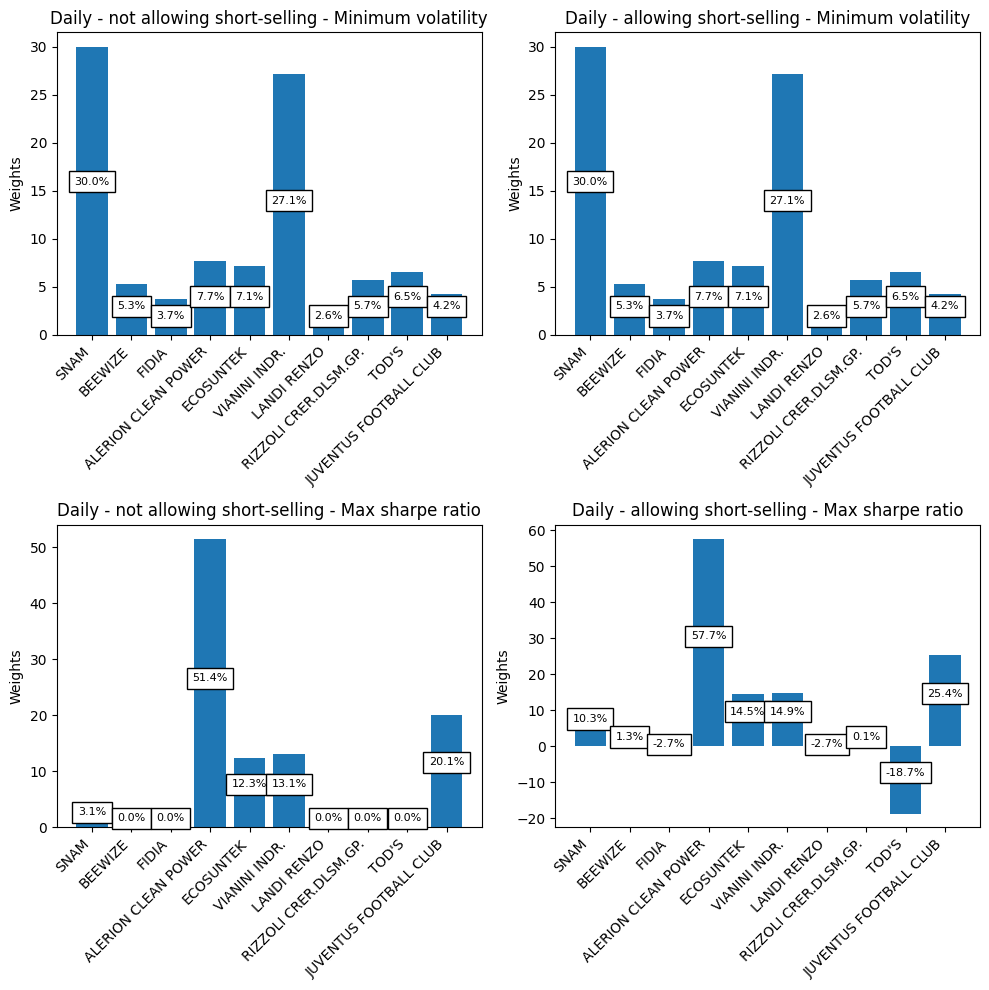

In [ ]:
# Portfolio Optimization - Daily data:  minimum volatility (non-negative)
ef_min_volatility_daily = EfficientFrontier(mu_daily, sigma_daily, weight_bounds=(0, 1))
weights_min_volatility_daily = ef_min_volatility_daily.min_volatility()
cleaned_weights_min_volatility_daily = pd.DataFrame(ef_min_volatility_daily.clean_weights().values(),
                                        index = portfolio_daily_returns.columns, columns=["Weight"])

# Portfolio Optimization - Daily data:  minimum volatility
ef_min_volatility_shorting_daily = EfficientFrontier(mu_daily, sigma_daily, weight_bounds=(-1, 1))
weights_min_volatility_shorting_daily = ef_min_volatility_shorting_daily.min_volatility()
cleaned_weights_min_volatility_shorting_daily = pd.DataFrame(ef_min_volatility_shorting_daily.clean_weights().values(),
                                         index = portfolio_daily_returns.columns, columns=["Weight"])

# Portfolio Optimization - Daily data:  maximal Sharpe ratio (a.k.a the tangency portfolio, non-negative)
ef_max_sharpe_ratio_daily = EfficientFrontier(mu_daily, sigma_daily, weight_bounds=(0, 1))
weights_max_sharpe_ratio_daily = ef_max_sharpe_ratio_daily.max_sharpe(risk_free_rate=0)
cleaned_weights_max_sharpe_ratio_daily = pd.DataFrame(ef_max_sharpe_ratio_daily.clean_weights().values(),
                                        index = portfolio_daily_returns.columns, columns=["Weight"])

# Portfolio Optimization - Daily data:  maximal Sharpe ratio (a.k.a the tangency portfolio)
ef_max_sharpe_ratio_shorting_daily = EfficientFrontier(mu_daily, sigma_daily, weight_bounds=(-1, 1))
weights_max_sharpe_ratio_shorting_daily = ef_max_sharpe_ratio_shorting_daily.max_sharpe(risk_free_rate=0)
cleaned_weights_max_sharpe_ratio_shorting_daily = pd.DataFrame(ef_max_sharpe_ratio_shorting_daily.clean_weights().values(),
                                         index = portfolio_daily_returns.columns, columns=["Weight"])


plot_weights_arr(
    weights_arr=[
        weights_min_volatility_daily,
        weights_min_volatility_shorting_daily,
        weights_max_sharpe_ratio_daily,
        weights_max_sharpe_ratio_shorting_daily
        ],
    title_arr=[
        'Daily - not allowing short-selling - Minimum volatility',
        'Daily - allowing short-selling - Minimum volatility',
        'Daily - not allowing short-selling - Max sharpe ratio',
        'Daily - allowing short-selling - Max sharpe ratio',
        ]
)



In [ ]:
# Portfolio Daily - not allowing short-selling - Minimum volatility
portfolio_daily_returns_min_volatility = pd.DataFrame(index = portfolio_daily_returns.index,
                                          columns = portfolio_daily_returns.columns)
portfolio_daily_returns_min_volatility = portfolio_weighted(portfolio_daily_returns, portfolio_daily_returns_min_volatility, cleaned_weights_min_volatility_daily)


# Portfolio Daily - allowing short-selling - Minimum volatility
portfolio_daily_returns_min_volatility_shorting = pd.DataFrame(index = portfolio_daily_returns.index,
                                           columns = portfolio_daily_returns.columns)
portfolio_daily_returns_min_volatility_shorting = portfolio_weighted(portfolio_daily_returns, portfolio_daily_returns_min_volatility_shorting, cleaned_weights_min_volatility_shorting_daily)


# Portfolio Daily - not allowing short-selling - Max sharpe ratio
portfolio_daily_returns_max_sharpe_ratio = pd.DataFrame(index = portfolio_daily_returns.index,
                                           columns = portfolio_daily_returns.columns)
portfolio_daily_returns_max_sharpe_ratio = portfolio_weighted(portfolio_daily_returns, portfolio_daily_returns_max_sharpe_ratio, cleaned_weights_max_sharpe_ratio_daily)


# Portfolio Daily - allowing short-selling - Max sharpe ratio
portfolio_daily_returns_max_sharpe_ratio_shorting = pd.DataFrame(index = portfolio_daily_returns.index,
                                           columns = portfolio_daily_returns.columns)
portfolio_daily_returns_max_sharpe_ratio_shorting = portfolio_weighted(portfolio_daily_returns, portfolio_daily_returns_max_sharpe_ratio_shorting, cleaned_weights_max_sharpe_ratio_shorting_daily)

In [ ]:
np.random.seed(42)
init_ret = portfolio_daily_returns
num_ports = 3000 # number of portfolios
all_weights = np.zeros((num_ports, len(init_ret.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(init_ret.columns)))
    weights = weights/np.sum(weights)

    # Save weights
    all_weights[x,:] = weights

    # Expected return
    ret_arr[x] = np.sum( (init_ret.mean() * weights))

    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(init_ret.cov(), weights)))

    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [ ]:
ef_max_sharpe_ratio_shorting_daily.portfolio_performance()

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.0011100298756772159, 0.017756657948949046, 0.06251344587864377)

In [ ]:
portfolio_daily_returns_max_sharpe_ratio_shorting.mean().mean()

0.0001110037780517566

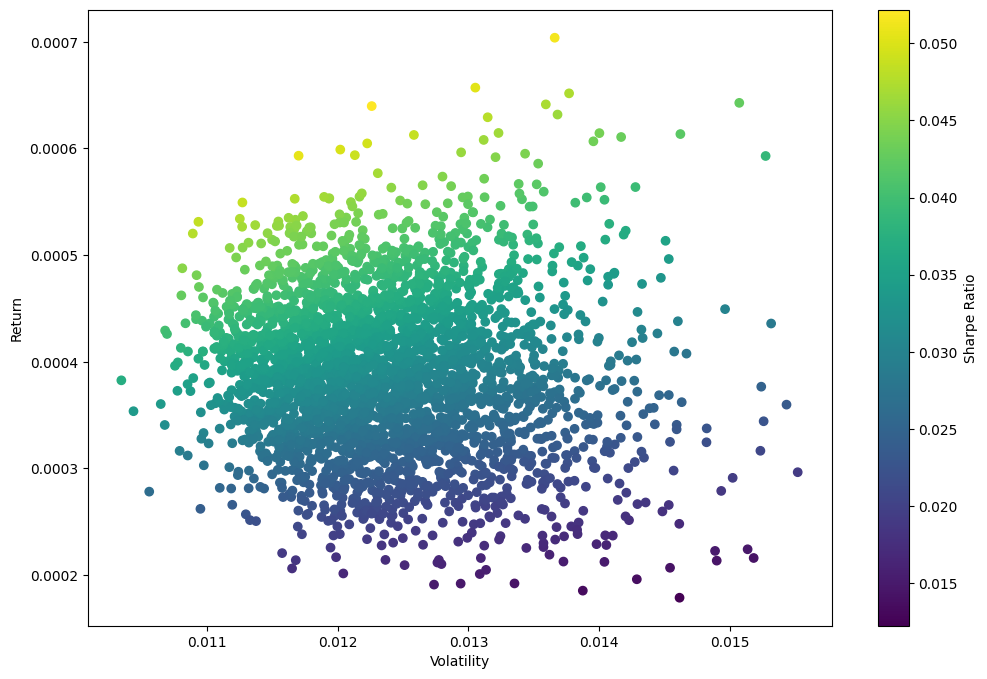

In [ ]:
pyplot.figure(figsize=(12,8))
pyplot.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
pyplot.colorbar(label='Sharpe Ratio')
pyplot.xlabel('Volatility')
pyplot.ylabel('Return')
pyplot.show()

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


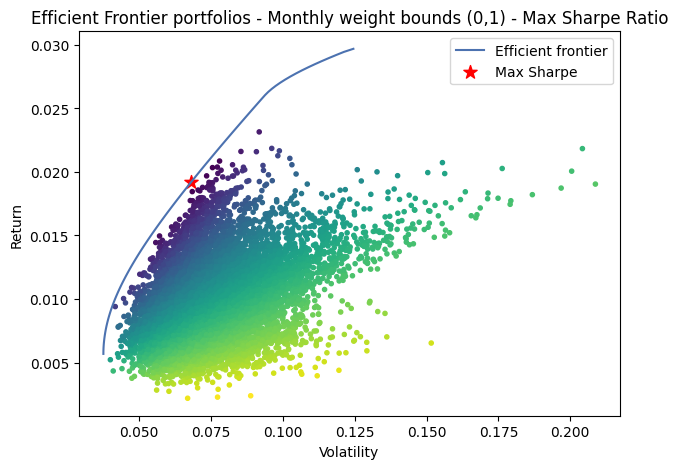

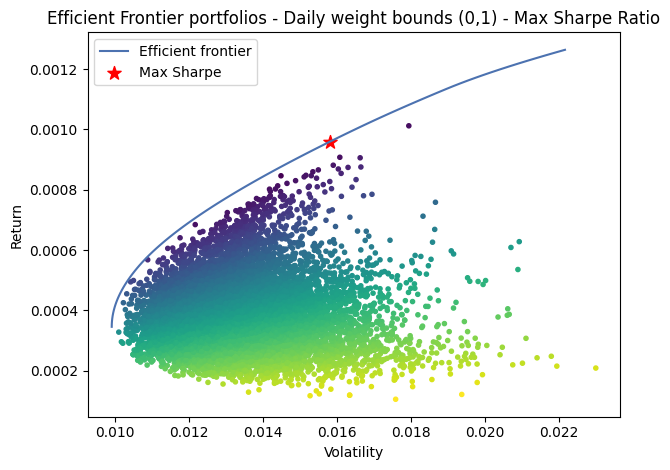

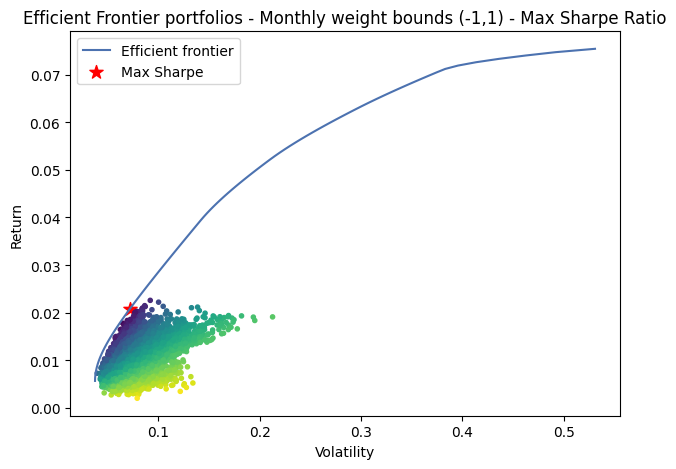

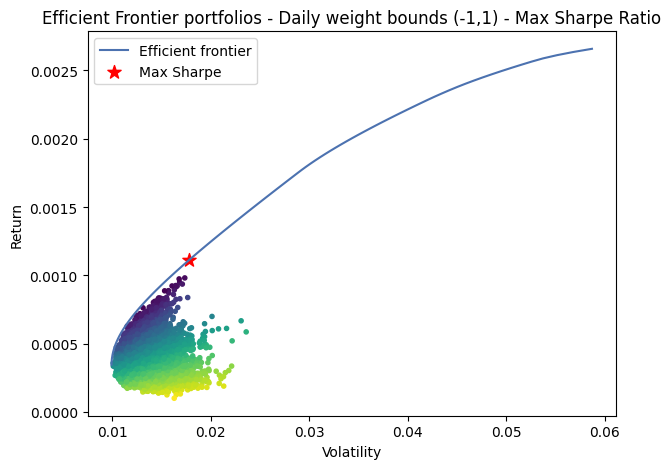

In [ ]:
from pypfopt.plotting import plot_efficient_frontier

def efficient_frontier(mu, S, weight_bounds, title):
  ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds)
  fig, ax = pyplot.subplots()
  ef_max_sharpe = ef.deepcopy()
  plot_efficient_frontier(ef, ax=ax, show_assets=False)
  # Find the tangency portfolio
  ef_max_sharpe.max_sharpe(risk_free_rate=0)
  ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
  ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")
  # Generate random portfolios
  n_samples = 10000
  w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
  rets = w.dot(ef.expected_returns)
  stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
  sharpes = rets / stds
  ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

  # Output
  ax.set_title(f"Efficient Frontier portfolios - {title} - Max Sharpe Ratio")
  ax.legend()
  pyplot.tight_layout()
  pyplot.show()


efficient_frontier(mu=mu_monthly, S=sigma_monthly, weight_bounds=(0,1), title='Monthly weight bounds (0,1)')
efficient_frontier(mu=mu_daily, S=sigma_daily, weight_bounds=(0,1), title='Daily weight bounds (0,1)')
efficient_frontier(mu=mu_monthly, S=sigma_monthly, weight_bounds=(-1,1), title='Monthly weight bounds (-1,1)')
efficient_frontier(mu=mu_daily, S=sigma_daily, weight_bounds=(-1,1), title='Daily weight bounds (-1,1)')

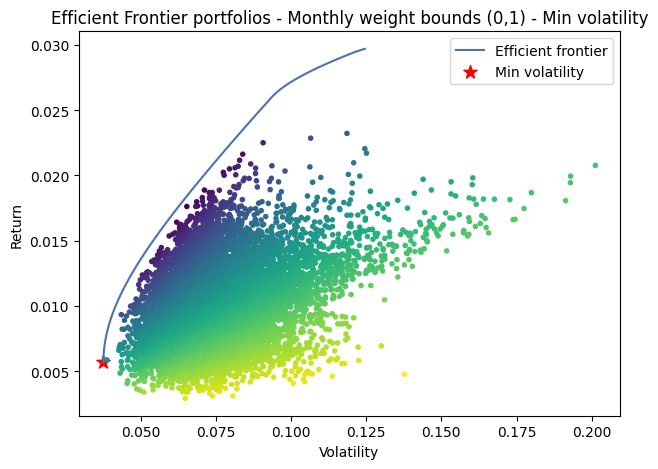

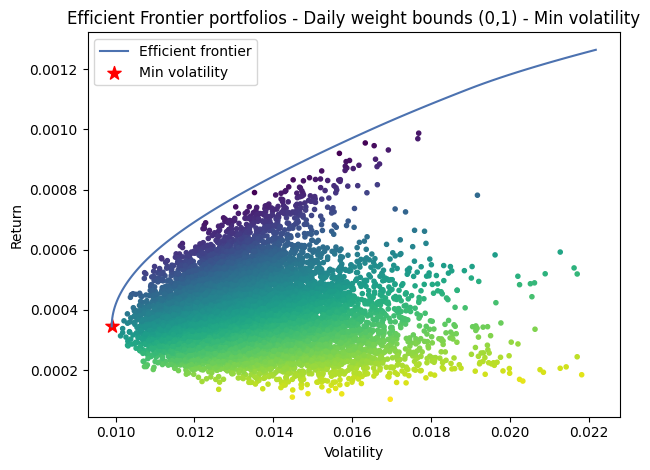

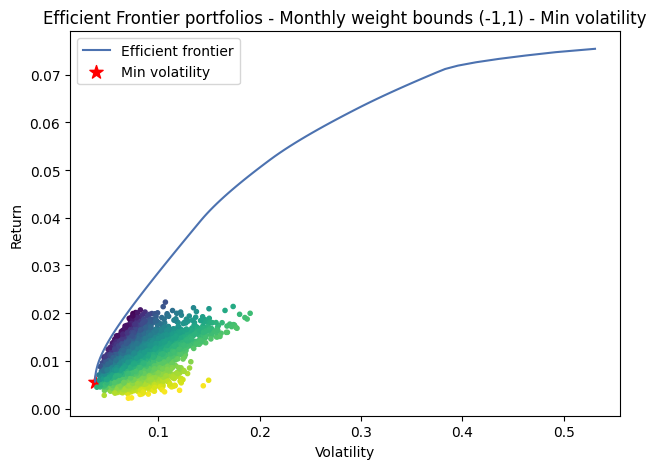

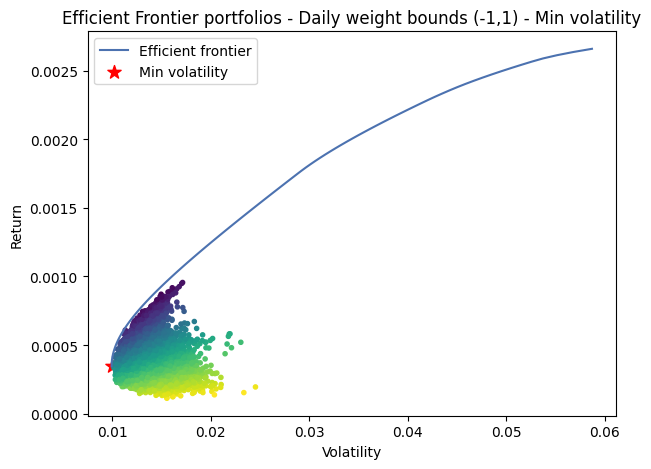

In [ ]:
from pypfopt.plotting import plot_efficient_frontier

def efficient_frontier_min_vol(mu, S, weight_bounds, title):
  ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds)
  fig, ax = pyplot.subplots()
  ef_max_sharpe = ef.deepcopy()
  plot_efficient_frontier(ef, ax=ax, show_assets=False)
  # Find the tangency portfolio
  ef_max_sharpe.min_volatility()
  ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
  ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min volatility")
  # Generate random portfolios
  n_samples = 10000
  w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
  rets = w.dot(ef.expected_returns)
  stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
  sharpes = rets / stds
  ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

  # Output
  ax.set_title(f"Efficient Frontier portfolios - {title} - Min volatility")
  ax.legend()
  pyplot.tight_layout()
  pyplot.show()


efficient_frontier_min_vol(mu=mu_monthly, S=sigma_monthly, weight_bounds=(0,1), title='Monthly weight bounds (0,1)')
efficient_frontier_min_vol(mu=mu_daily, S=sigma_daily, weight_bounds=(0,1), title='Daily weight bounds (0,1)')
efficient_frontier_min_vol(mu=mu_monthly, S=sigma_monthly, weight_bounds=(-1,1), title='Monthly weight bounds (-1,1)')
efficient_frontier_min_vol(mu=mu_daily, S=sigma_daily, weight_bounds=(-1,1), title='Daily weight bounds (-1,1)')

In [ ]:
def get_stats_portfolio(portfolio_daily, portfolio_monthly):
  df_mean = pd.DataFrame({"Daily" : portfolio_daily.mean(), "Monthly" : portfolio_monthly.mean()})
  df_std = pd.DataFrame({"Daily" : portfolio_daily.std(), "Monthly" : portfolio_monthly.std()})
  df_var = pd.DataFrame({"Daily" : portfolio_daily.var(), "Monthly" : portfolio_monthly.var()})
  df_skew = pd.DataFrame({"Daily" : portfolio_daily.skew(), "Monthly" : portfolio_monthly.skew()})
  df_kurt = pd.DataFrame({"Daily" : portfolio_daily.kurtosis(), "Monthly" : portfolio_monthly.kurtosis()})

  return pd.concat([
      df_mean.mean(),
      df_std.mean(),
      df_var.mean(),
      df_skew.mean(),
      df_kurt.mean()
      ], axis = 1)

In [ ]:
portfolio_max_sharpe_ratio_shorting_stats = get_stats_portfolio(portfolio_daily_returns_max_sharpe_ratio_shorting, portfolio_monthly_returns_max_sharpe_ratio_shorting)
portfolio_max_sharpe_ratio_shorting_stats.columns = ["Mean", "Std", "Var", "Skewness", "Kurtosis"]
portfolio_max_sharpe_ratio_shorting_stats.round(5)

Mean      Std      Var  Skewness  Kurtosis
Daily    0.00011  0.00365  0.00003   0.25048  13.75112
Monthly  0.00208  0.01640  0.00057   0.54199  17.57907

In [ ]:
portfolio_max_sharpe_ratio_stats = get_stats_portfolio(portfolio_daily_returns_max_sharpe_ratio, portfolio_monthly_returns_max_sharpe_ratio)
portfolio_max_sharpe_ratio_stats.columns = ["Mean", "Std", "Var", "Skewness", "Kurtosis"]
portfolio_max_sharpe_ratio_stats.round(5)

Mean      Std      Var  Skewness  Kurtosis
Daily    0.00010  0.00251  0.00002   0.36615   5.96707
Monthly  0.00192  0.01174  0.00045   1.61649  11.21049

In [ ]:
portfolio_min_volatility_shorting_stats = get_stats_portfolio(portfolio_daily_returns_min_volatility_shorting, portfolio_monthly_returns_min_volatility_shorting)
portfolio_min_volatility_shorting_stats.columns = ["Mean", "Std", "Var", "Skewness", "Kurtosis"]
portfolio_min_volatility_shorting_stats.round(5)

Mean      Std      Var  Skewness  Kurtosis
Daily    0.00003  0.00213  0.00001   1.15483  13.75112
Monthly  0.00057  0.00721  0.00011   0.46346  17.57907

In [ ]:
portfolio_min_volatility_stats = get_stats_portfolio(portfolio_daily_returns_min_volatility, portfolio_monthly_returns_min_volatility)
portfolio_min_volatility_stats.columns = ["Mean", "Std", "Var", "Skewness", "Kurtosis"]
portfolio_min_volatility_stats.round(5)

Mean      Std      Var  Skewness  Kurtosis
Daily    0.00003  0.00213  0.00001   1.15483  13.75112
Monthly  0.00057  0.00697  0.00011   1.57723   8.54535

In [ ]:
print('Min volatility')
pd.concat([portfolio_min_volatility_stats.round(5), portfolio_min_volatility_shorting_stats.round(5)], keys=['Not Shorting','Shorting'])

Min volatility


Mean      Std      Var  Skewness  Kurtosis
Not Shorting Daily    0.00003  0.00213  0.00001   1.15483  13.75112
             Monthly  0.00057  0.00697  0.00011   1.57723   8.54535
Shorting     Daily    0.00003  0.00213  0.00001   1.15483  13.75112
             Monthly  0.00057  0.00721  0.00011   0.46346  17.57907

In [ ]:
print('Max sharp ratio')
pd.concat([portfolio_max_sharpe_ratio_stats.round(5), portfolio_max_sharpe_ratio_shorting_stats.round(5)], keys=['Not Shorting','Shorting'])

Max sharp ratio


Mean      Std      Var  Skewness  Kurtosis
Not Shorting Daily    0.00010  0.00251  0.00002   0.36615   5.96707
             Monthly  0.00192  0.01174  0.00045   1.61649  11.21049
Shorting     Daily    0.00011  0.00365  0.00003   0.25048  13.75112
             Monthly  0.00208  0.01640  0.00057   0.54199  17.57907

# Punto 9 - 10

In [ ]:
ftse_daily = pd.read_excel(r'sample_data/Data for CAPM.xlsx', sheet_name=0, index_col=0)
ftse_monthly = pd.read_excel(r'sample_data/Data for CAPM.xlsx', sheet_name=1, index_col=0)
ret_daily = pd.read_excel(r'sample_data/Data for CAPM.xlsx', sheet_name=2, index_col=0)
ret_monthly = pd.read_excel(r'sample_data/Data for CAPM.xlsx', sheet_name=3,index_col=0)

In [ ]:
def calculate_beta(security_returns, market_returns):
    covariance = np.cov(security_returns.dropna().values, market_returns.dropna().values.flatten())
    beta = covariance[0,1] / np.var(market_returns.dropna().values.flatten())
    return beta

In [ ]:
#daily
betas_daily = []
for column in ret_daily.columns:
    security_returns = ret_daily[column]
    beta = calculate_beta(security_returns, ftse_daily)
    betas_daily.append(beta)

In [ ]:
#monthly
betas_monthly = []
for column in ret_monthly.columns:
    security_returns = ret_monthly[column]
    beta = calculate_beta(security_returns, ftse_monthly)
    betas_monthly.append(beta)

In [ ]:
annualized_ret_monthly = (ret_monthly.mean()*12).tolist()
annualized_ret_daily = (ret_daily.mean()*252).tolist()
ret_monthly.columns

Index(['M ECOSUNTEK', 'M LANDI RENZO', 'M ALERION CLEAN POWER', 'M FIDIA',
       'M RIZZOLI CRER.DLSM.GP.', 'M SNAM', 'M TOD'S', 'M BEEWIZE',
       'M JUVENTUS FOOTBALL CLUB', 'M VIANINI INDR.', 'portfolio ret'],
      dtype='object')

In [ ]:
def remove_m_prefix(array):
    return [string.replace("M ", "") for string in array]


In [ ]:
ret_monthly.columns = remove_m_prefix(ret_monthly.columns)

In [ ]:
def plot_security_market(market_return, beta_portfolio = 1, risk_free_rate = 0.03, title = '', betas_input = [], stock_names = [], annualized_ret=[], only_portfolio=False):
  expected_return_portfolio = risk_free_rate + beta_portfolio * (market_return - risk_free_rate)
  beta_values = np.linspace(0, 2, 100)
  sml = risk_free_rate + beta_values * (market_return - risk_free_rate)
  pyplot.figure(figsize=(10, 6))
  pyplot.grid(linewidth = 0.5, alpha = 0.25)
  pyplot.plot(beta_values, sml, label=title, color='blue',  alpha=0.3)
  colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black']  # Colors for different stocks
  for i in range(11):  # Change according to number of stocks
    if only_portfolio is True:
      i = 10

    stock_name = ''
    if i == 10:
      stock_name = 'Portfolio'
    else:
      stock_name = stock_names[i]
    pyplot.scatter(betas_input[i], annualized_ret[i], color=colors[i])
    pyplot.text(betas_input[i], annualized_ret[i], f'{stock_name}', verticalalignment='bottom')
  pyplot.scatter(beta_portfolio, expected_return_portfolio, color='green',  marker="*", s=300)
  pyplot.annotate('Market', xy=(beta_portfolio, expected_return_portfolio),  xycoords='data',
             xytext=(0, 20), textcoords='offset points',
             size=13, ha='center', va="center")
  pyplot.xlabel('Beta')
  pyplot.ylabel('Expected Return')
  pyplot.legend()
  pyplot.title(title)
  pyplot.grid(True)
  pyplot.show()

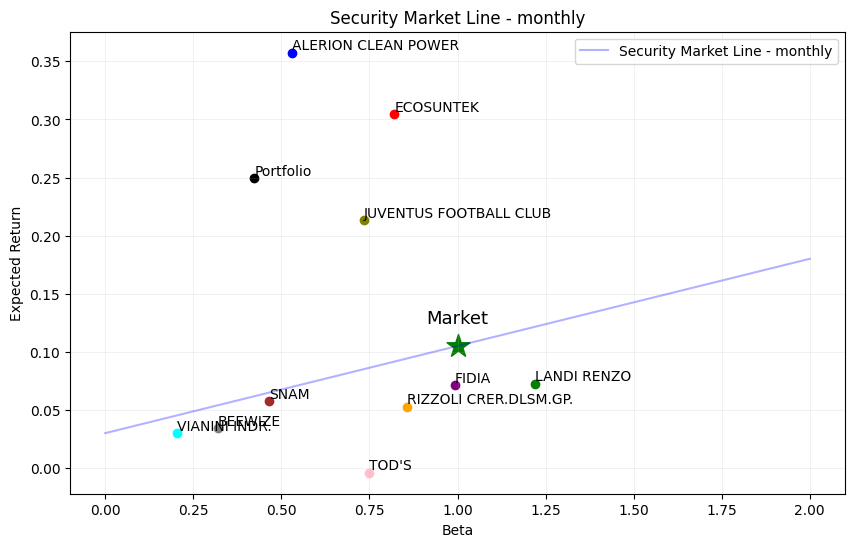

In [ ]:
plot_security_market(
    market_return=ftse_monthly.mean().squeeze()*12,
    beta_portfolio = 1,
    risk_free_rate = 0.03,
    title = 'Security Market Line - monthly',
    betas_input = betas_monthly,
    stock_names=ret_monthly.columns,
    annualized_ret=annualized_ret_monthly,
    only_portfolio=False
    )

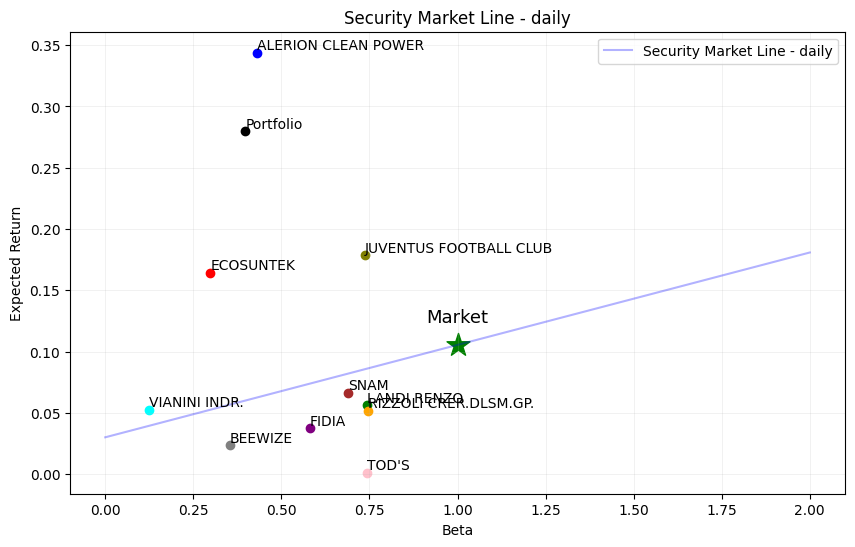

In [ ]:
plot_security_market(
    market_return=ftse_daily.mean().squeeze()*252,
    beta_portfolio = 1,
    risk_free_rate = 0.03,
    title = 'Security Market Line - daily',
    betas_input = betas_daily,
    stock_names=ret_daily.columns,
    annualized_ret=annualized_ret_daily,
    only_portfolio=False
    )

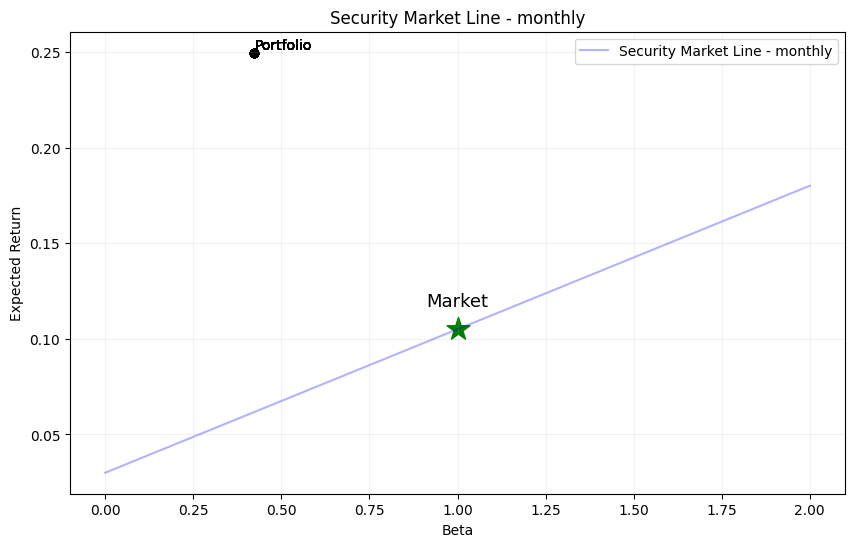

In [ ]:
plot_security_market(
    market_return=ftse_monthly.mean().squeeze()*12,
    beta_portfolio = 1,
    risk_free_rate = 0.03,
    title = 'Security Market Line - monthly',
    betas_input = betas_monthly,
    stock_names=ret_monthly.columns,
    annualized_ret=annualized_ret_monthly,
    only_portfolio=True
    )

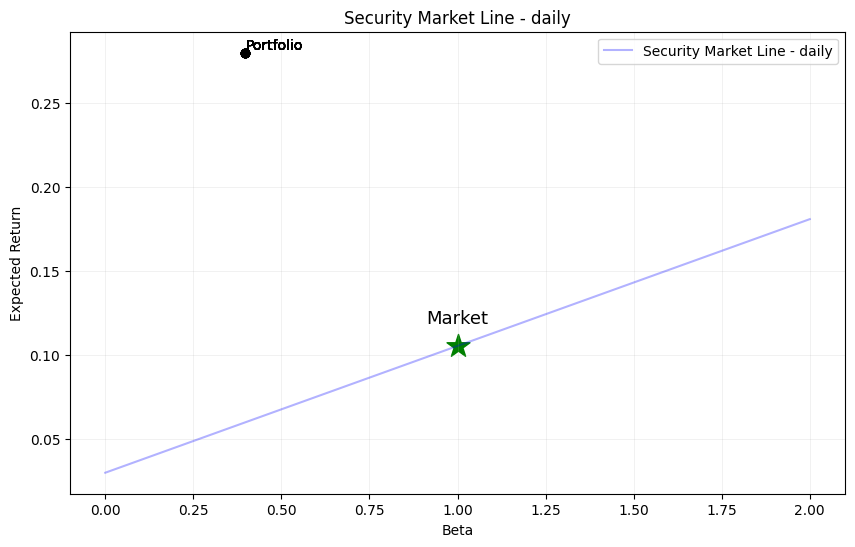

In [ ]:
plot_security_market(
    market_return=ftse_daily.mean().squeeze()*252,
    beta_portfolio = 1,
    risk_free_rate = 0.03,
    title = 'Security Market Line - daily',
    betas_input = betas_daily,
    stock_names=ret_daily.columns,
    annualized_ret=annualized_ret_daily,
    only_portfolio=True
    )

In [ ]:
def plot_security_market_two_stocks(market_return, beta_mm = [], ret_mm = [], risk_free_rate = 0.03, beta_portfolio = 1, period = '', stock_names = []):
  expected_return_portfolio = risk_free_rate + beta_portfolio * (market_return - risk_free_rate)
  beta_values = np.linspace(0, 2, 100)
  sml = risk_free_rate + beta_values * (market_return - risk_free_rate)
  pyplot.figure(figsize=(10, 6))
  pyplot.grid(linewidth = 0.5, alpha = 0.25)
  pyplot.plot(beta_values, sml, label=f'Security Market Line - {period} 2 stocks', color='blue', alpha=0.3)
  colors = ['red', 'green']
  for i in range(2):  # Change according to number of stocks
    pyplot.scatter(beta_mm[i], ret_mm[i], color=colors[i])
    pyplot.text(beta_mm[i], ret_mm[i], f'{stock_names[i]}', verticalalignment='bottom')
  pyplot.scatter(beta_portfolio, expected_return_portfolio, color='green',  marker="*", s=300)
  pyplot.annotate('Market', xy=(beta_portfolio, expected_return_portfolio),  xycoords='data',
             xytext=(0, 20), textcoords='offset points',
             size=13, ha='center', va="center")
  pyplot.xlabel('Beta')
  pyplot.ylabel('Expected Return')
  pyplot.legend()
  pyplot.title(f'Security Market Line - {period}')
  pyplot.grid(True)
  pyplot.show()

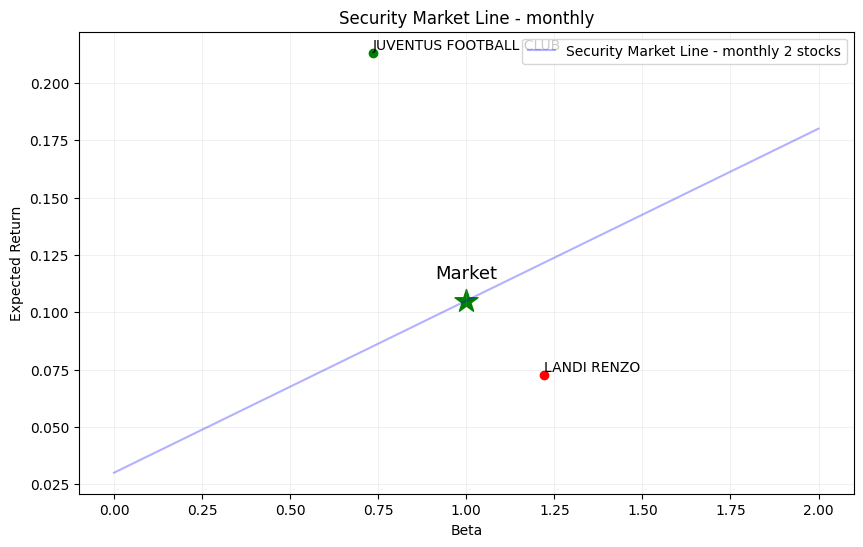

In [ ]:
plot_security_market_two_stocks(
    market_return = ftse_monthly.mean().squeeze()*12,
    beta_mm =[betas_monthly[1], betas_monthly[8]],
    ret_mm = [annualized_ret_monthly[1], annualized_ret_monthly[8]],
    risk_free_rate = 0.03,
    beta_portfolio = 1,
    period = 'monthly',
    stock_names=[ret_monthly.columns[1],ret_monthly.columns[8]]
)


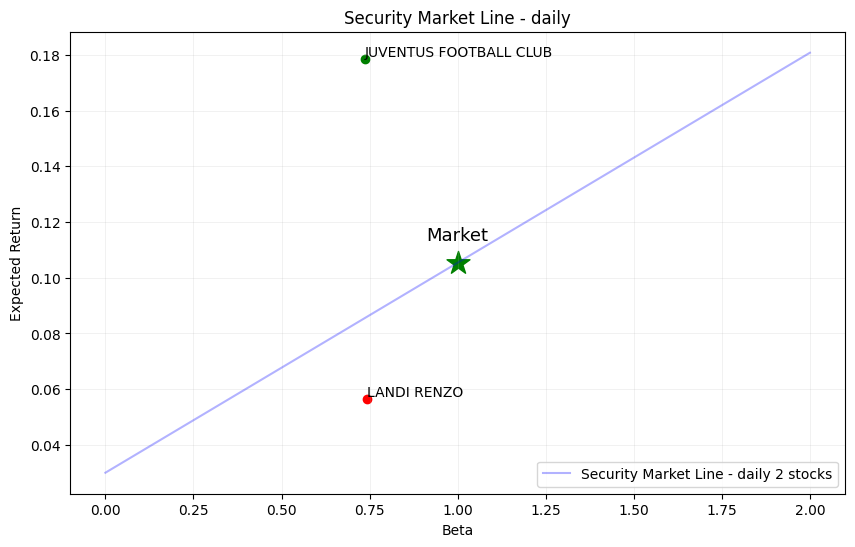

In [ ]:
plot_security_market_two_stocks(
    market_return = ftse_daily.mean().squeeze()*252,
    beta_mm = [betas_daily[1], betas_daily[8]],
    ret_mm = [annualized_ret_daily[1], annualized_ret_daily[8]],
    risk_free_rate = 0.03,
    beta_portfolio = 1,
    period = 'daily',
    stock_names=[ret_daily.columns[1],ret_daily.columns[8]]
)

# Black Litterman Allocation

## Daily

In [ ]:
selected_daily.tail()

SNAM BEEWIZE  FIDIA ALERION CLEAN POWER ECOSUNTEK VIANINI INDR.  \
Date                                                                           
2023-06-28  4.745   0.656  1.365                28.2      20.5          1.26   
2023-06-29  4.771   0.656  1.365                28.4      20.6          1.31   
2023-06-30  4.787    0.69  1.375                28.6      20.1          1.31   
2023-07-03  4.818   0.672   1.33                28.5      20.1          1.31   
2023-07-04  4.772   0.672   1.39               28.95     19.65          1.31   

           LANDI RENZO RIZZOLI CRER.DLSM.GP.  TOD'S JUVENTUS FOOTBALL CLUB  
Date                                                                        
2023-06-28       0.536                 0.717  37.86                 0.3338  
2023-06-29       0.536                 0.715  37.94                   0.34  
2023-06-30       0.547                 0.729  38.44                  0.343  
2023-07-03       0.545                  0.73   38.7                 0.3514  
2023-07-04       0.537                  0.73  41.24                 0.3624

In [ ]:
#market_prices
ftse_daily = pd.read_excel(r'sample_data/Clean data.xlsx', sheet_name='FTSE Daily ', index_col=0).iloc[:,0]
ftse_daily

Date
2015-01-01    24979.66
2015-01-02    25150.98
2015-01-05    24026.63
2015-01-06    23941.42
2015-01-07    23903.53
                ...   
2023-06-28    49770.43
2023-06-29    50252.19
2023-06-30    50783.36
2023-07-03    51121.09
2023-07-04    51024.43
Name: FTSE ITALIA ALL SHARE - TOT RETURN IND, Length: 2219, dtype: float64

In [ ]:
mcaps = {
    'SNAM': 15.54,
    'BEEWIZE': 0.00713,
    'FIDIA': 0.00923,
    'ALERION CLEAN POWER': 1.53,
    'ECOSUNTEK': 0.03367,
    'VIANINI INDR.': 0.03974,
    'LANDI RENZO': 0.12217,
    'RIZZOLI CRER.DLSM.GP.': 0.36429,
    "TOD'S": 1.41,
    'JUVENTUS FOOTBALL CLUB':  0.91242
}

for key in mcaps:
    mcaps[key] =  int(mcaps[key] * 10**9)

mcaps

{'SNAM': 15540000000,
 'BEEWIZE': 7130000,
 'FIDIA': 9230000,
 'ALERION CLEAN POWER': 1530000000,
 'ECOSUNTEK': 33670000,
 'VIANINI INDR.': 39740000,
 'LANDI RENZO': 122170000,
 'RIZZOLI CRER.DLSM.GP.': 364290000,
 "TOD'S": 1410000000,
 'JUVENTUS FOOTBALL CLUB': 912420000}

In [ ]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(selected_daily).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(ftse_daily, frequency=252, risk_free_rate=0.03)
delta

1.5759714780329532

In [ ]:
# plotting.plot_covariance(S, plot_correlation=True);

In [ ]:
market_prior_daily = black_litterman.market_implied_prior_returns(mcaps, delta, S, risk_free_rate=0.03)
market_prior_daily

SNAM                      0.112064
BEEWIZE                   0.048730
FIDIA                     0.057374
ALERION CLEAN POWER       0.075478
ECOSUNTEK                 0.041983
VIANINI INDR.             0.036904
LANDI RENZO               0.069006
RIZZOLI CRER.DLSM.GP.     0.065418
TOD'S                     0.074952
JUVENTUS FOOTBALL CLUB    0.075633
dtype: float64

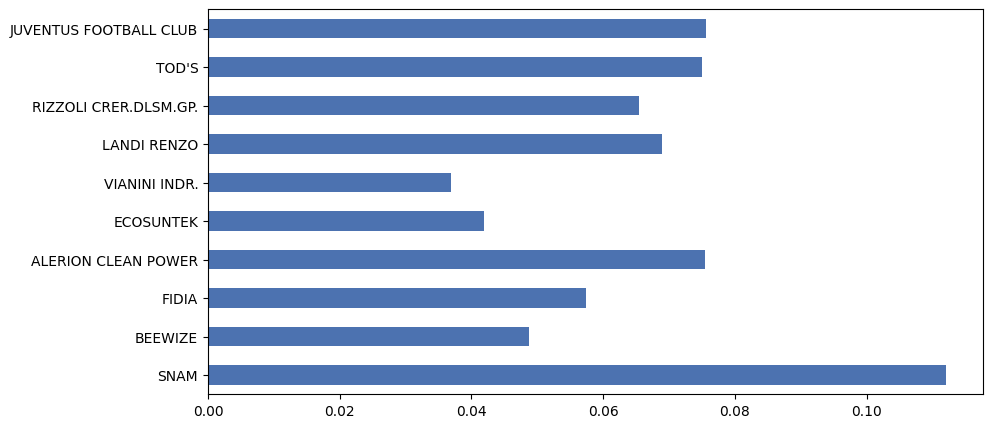

In [ ]:
market_prior_daily.plot.barh(figsize=(10,5));

In [ ]:
P = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [-1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, -1, 0, 0, 0, 0, 0, 0, 0, 1],
    ]
)

Q = np.array([
    -0.044,
    0.268,
    0.263,
    0.126
]).reshape(-1, 1)

confidences = [
    0.33,
    0.33,
    0.33,
    0.67
]

bl = BlackLittermanModel(S, pi=market_prior_daily, P=P, Q=Q, omega="idzorek", view_confidences=confidences, risk_free_rate=0.03)
omega = bl.omega
np.diag(bl.omega)

array([0.01347646, 0.0165368 , 0.01912823, 0.01015465])

### Posterior estimates

In [ ]:
bl = BlackLittermanModel(S, pi='market', P=P, Q=Q, market_caps=mcaps, omega=omega, risk_aversion=delta, risk_free_rate=0.03)

In [ ]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

SNAM                      0.092201
BEEWIZE                   0.004726
FIDIA                     0.061507
ALERION CLEAN POWER       0.153542
ECOSUNTEK                 0.046864
VIANINI INDR.             0.038015
LANDI RENZO               0.074046
RIZZOLI CRER.DLSM.GP.     0.125868
TOD'S                     0.044860
JUVENTUS FOOTBALL CLUB    0.099665
dtype: float64

In [ ]:
rets_df = pd.DataFrame([market_prior_daily, ret_bl], index=["Prior", "Posterior"]).T
rets_df

Prior  Posterior
SNAM                    0.112064   0.092201
BEEWIZE                 0.048730   0.004726
FIDIA                   0.057374   0.061507
ALERION CLEAN POWER     0.075478   0.153542
ECOSUNTEK               0.041983   0.046864
VIANINI INDR.           0.036904   0.038015
LANDI RENZO             0.069006   0.074046
RIZZOLI CRER.DLSM.GP.   0.065418   0.125868
TOD'S                   0.074952   0.044860
JUVENTUS FOOTBALL CLUB  0.075633   0.099665

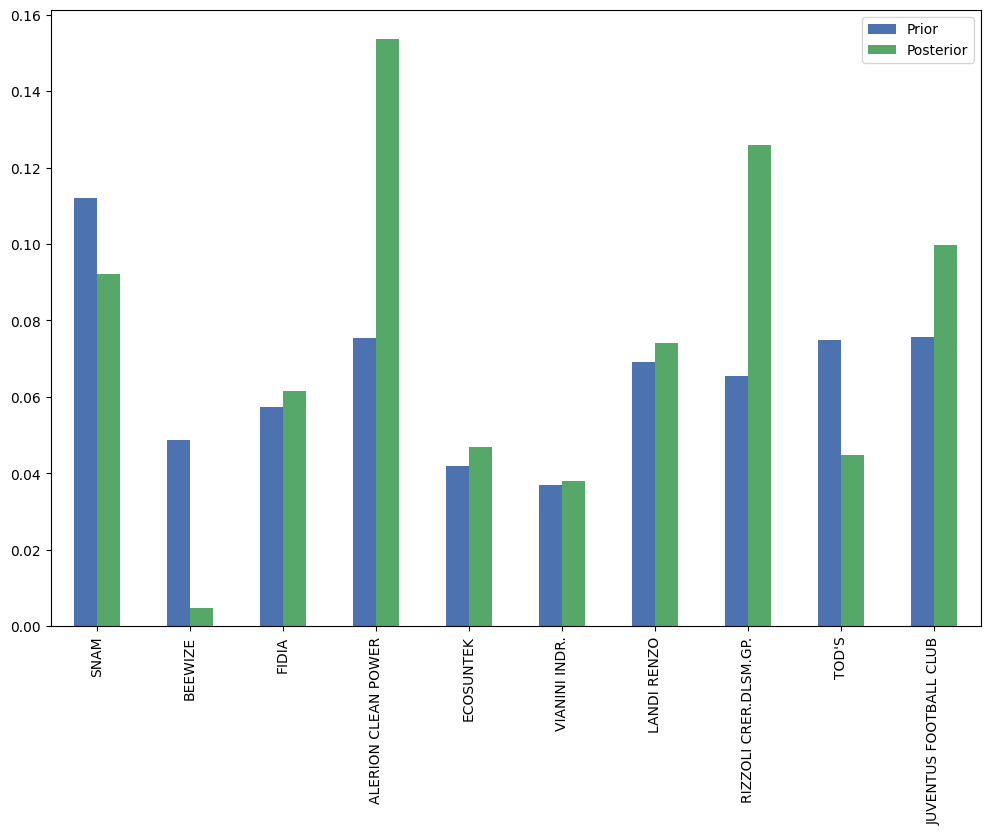

In [ ]:
rets_df.plot.bar(figsize=(12,8));

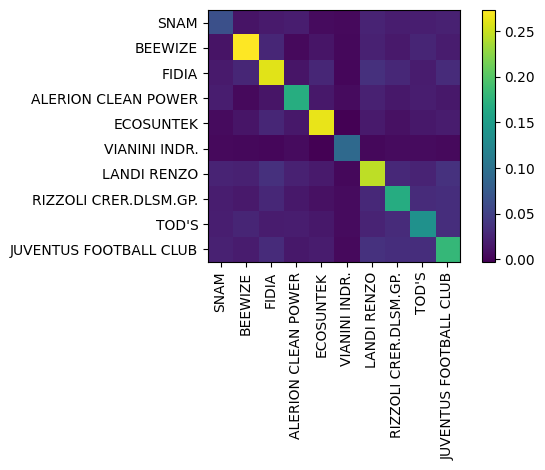

In [ ]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

### Portfolio Allocation

In [ ]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S_bl, weight_bounds=(-1,1))
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe(risk_free_rate=0)
weights = ef.clean_weights()
weights

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('SNAM', 0.14048),
             ('BEEWIZE', -0.00417),
             ('FIDIA', 0.07162),
             ('ALERION CLEAN POWER', 0.22468),
             ('ECOSUNTEK', 0.05687),
             ('VIANINI INDR.', 0.05907),
             ('LANDI RENZO', 0.08794),
             ('RIZZOLI CRER.DLSM.GP.', 0.17819),
             ("TOD'S", 0.05161),
             ('JUVENTUS FOOTBALL CLUB', 0.1337)])

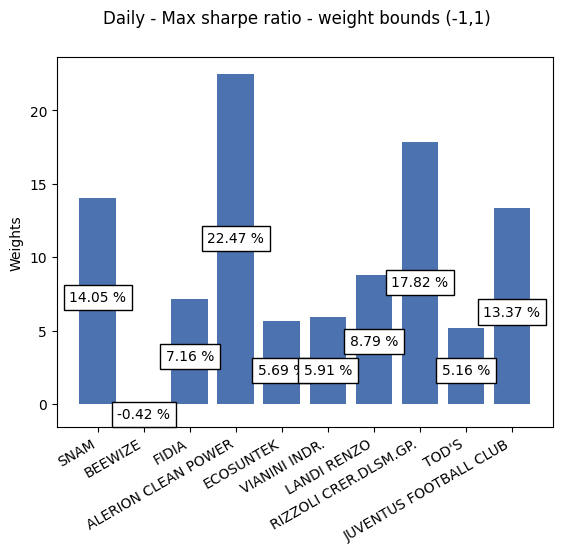

In [ ]:
plot_weights(weights, 'Daily - Max sharpe ratio - weight bounds (-1,1)')

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


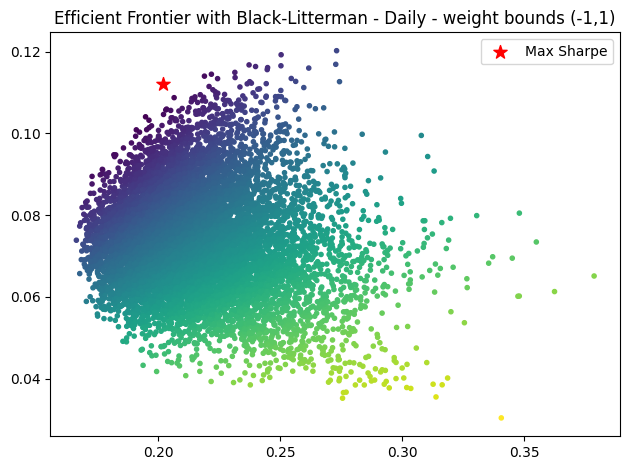

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl, weight_bounds=(-1,1))
fig, ax = pyplot.subplots()
ef_max_sharpe = ef.deepcopy()
# plot_efficient_frontier(ef, ax=ax, show_assets=False)
# Find the tangency portfolio
ef_max_sharpe.max_sharpe(risk_free_rate=0)
ret_tangent, std_tangent, sharpe_ratio_tangent = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")
# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title(f"Efficient Frontier with Black-Litterman - Daily - weight bounds (-1,1)")
ax.legend()
pyplot.tight_layout()
pyplot.show()

In [ ]:
ret_bl

SNAM                      0.092201
BEEWIZE                   0.004726
FIDIA                     0.061507
ALERION CLEAN POWER       0.153542
ECOSUNTEK                 0.046864
VIANINI INDR.             0.038015
LANDI RENZO               0.074046
RIZZOLI CRER.DLSM.GP.     0.125868
TOD'S                     0.044860
JUVENTUS FOOTBALL CLUB    0.099665
dtype: float64

In [ ]:
weights.values()

odict_values([0.14048, -0.00417, 0.07162, 0.22468, 0.05687, 0.05907, 0.08794, 0.17819, 0.05161, 0.1337])

In [ ]:
print(f"Sharpe ratio:               {sharpe_ratio_tangent}")
print(f'Return portfolio - Daily    : {ret_tangent}')
print(f'Standard deviation - Daily  : {std_tangent}')
print(f'Kurtosis - Daily            : {ret_bl.kurtosis()}')
print(f'Skewness - Daily            : {ret_bl.skew()}')


Sharpe ratio:               0.5549571115374307
Return portfolio - Daily    : 0.11203056544750017
Standard deviation - Daily  : 0.20187247468031402
Kurtosis - Daily            : -0.24759610175500235
Skewness - Daily            : 0.3667428911523968


## Monthly

In [ ]:
selected_monthly.tail()

SNAM BEEWIZE  FIDIA ALERION CLEAN POWER ECOSUNTEK VIANINI INDR.  \
Date                                                                           
2023-03-01  4.569   0.734   1.46                30.1      19.2           1.1   
2023-04-01  4.903   0.702  1.425               29.35     19.25          1.28   
2023-05-01   5.04   0.696    1.4                29.2      18.8          1.37   
2023-06-01  4.916   0.696   1.37                30.2        20          1.28   
2023-07-01  4.818   0.672   1.33                28.5      20.1          1.31   

           LANDI RENZO RIZZOLI CRER.DLSM.GP.  TOD'S JUVENTUS FOOTBALL CLUB  
Date                                                                        
2023-03-01       0.562                 0.726   35.9                 0.3026  
2023-04-01       0.568                 0.749  37.84                  0.339  
2023-05-01       0.556                 0.784   38.3                 0.2894  
2023-06-01       0.503                 0.706  37.48                  0.316  
2023-07-01       0.545                  0.73   38.7                 0.3514

In [ ]:
#market_prices
ftse_monthly = pd.read_excel(r'sample_data/Clean data.xlsx', sheet_name='FTSE Monthly ', index_col=0).iloc[:,0]
ftse_monthly

Date
2015-01-01    24979.66
2015-02-01    27005.46
2015-03-01    29436.23
2015-04-01    30945.60
2015-05-01    30586.00
                ...   
2023-03-01    48109.69
2023-04-01    47861.25
2023-05-01    48245.64
2023-06-01    47922.53
2023-07-01    51121.09
Name: FTSE ITALIA ALL SHARE - TOT RETURN IND, Length: 103, dtype: float64

In [ ]:
mcaps = {
    'SNAM': 15.54,
    'BEEWIZE': 0.00713,
    'FIDIA': 0.00923,
    'ALERION CLEAN POWER': 1.53,
    'ECOSUNTEK': 0.03367,
    'VIANINI INDR.': 0.03974,
    'LANDI RENZO': 0.12217,
    'RIZZOLI CRER.DLSM.GP.': 0.36429,
    "TOD'S": 1.41,
    'JUVENTUS FOOTBALL CLUB':  0.91242
}

for key in mcaps:
    mcaps[key] =  int(mcaps[key] * 10**9)

mcaps

{'SNAM': 15540000000,
 'BEEWIZE': 7130000,
 'FIDIA': 9230000,
 'ALERION CLEAN POWER': 1530000000,
 'ECOSUNTEK': 33670000,
 'VIANINI INDR.': 39740000,
 'LANDI RENZO': 122170000,
 'RIZZOLI CRER.DLSM.GP.': 364290000,
 "TOD'S": 1410000000,
 'JUVENTUS FOOTBALL CLUB': 912420000}

In [ ]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(selected_monthly, frequency=12).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(ftse_monthly, frequency=12, risk_free_rate=0.03)
delta

1.851989877961943

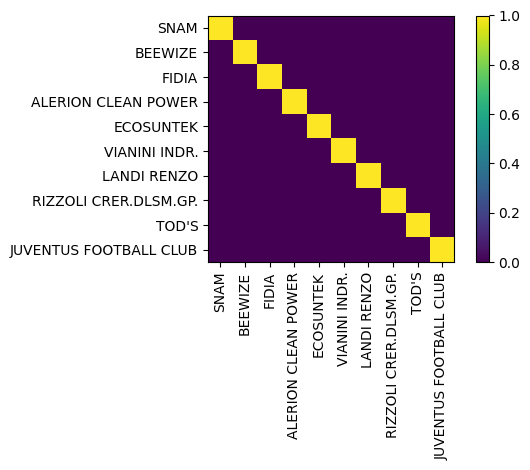

In [ ]:
plotting.plot_covariance(S, plot_correlation=True);

In [ ]:
market_prior_monthly = black_litterman.market_implied_prior_returns(mcaps, delta, S, risk_free_rate=0.03)
market_prior_monthly

SNAM                      0.484606
BEEWIZE                   0.030209
FIDIA                     0.030270
ALERION CLEAN POWER       0.074759
ECOSUNTEK                 0.030985
VIANINI INDR.             0.031163
LANDI RENZO               0.033574
RIZZOLI CRER.DLSM.GP.     0.040657
TOD'S                     0.071248
JUVENTUS FOOTBALL CLUB    0.056692
dtype: float64

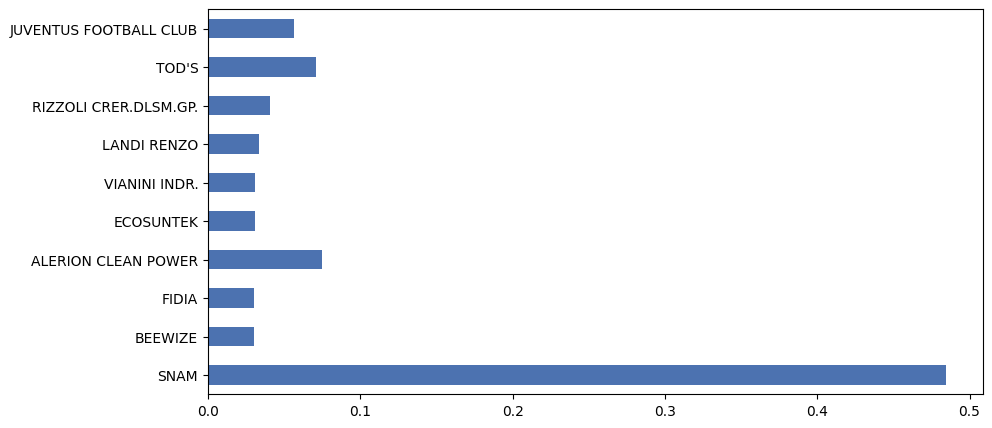

In [ ]:
market_prior_monthly.plot.barh(figsize=(10,5));

In [ ]:
bl = BlackLittermanModel(S, pi=market_prior_monthly, P=P, Q=Q, omega="idzorek", view_confidences=confidences, risk_free_rate=0.03)
omega = bl.omega
np.diag(bl.omega)

array([0.03202031, 0.03202031, 0.06404063, 0.01553581])

### Posterior estimates

In [ ]:
bl = BlackLittermanModel(S, pi='market', P=P, Q=Q, market_caps=mcaps, omega=omega, risk_aversion=delta, risk_free_rate=0.03)

In [ ]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

SNAM                      0.373587
BEEWIZE                  -0.003130
FIDIA                     0.030270
ALERION CLEAN POWER       0.185778
ECOSUNTEK                 0.030985
VIANINI INDR.             0.031163
LANDI RENZO               0.033574
RIZZOLI CRER.DLSM.GP.     0.115680
TOD'S                     0.033216
JUVENTUS FOOTBALL CLUB    0.090030
dtype: float64

In [ ]:
rets_df = pd.DataFrame([market_prior_monthly, ret_bl], index=["Prior", "Posterior"]).T
rets_df

Prior  Posterior
SNAM                    0.484606   0.373587
BEEWIZE                 0.030209  -0.003130
FIDIA                   0.030270   0.030270
ALERION CLEAN POWER     0.074759   0.185778
ECOSUNTEK               0.030985   0.030985
VIANINI INDR.           0.031163   0.031163
LANDI RENZO             0.033574   0.033574
RIZZOLI CRER.DLSM.GP.   0.040657   0.115680
TOD'S                   0.071248   0.033216
JUVENTUS FOOTBALL CLUB  0.056692   0.090030

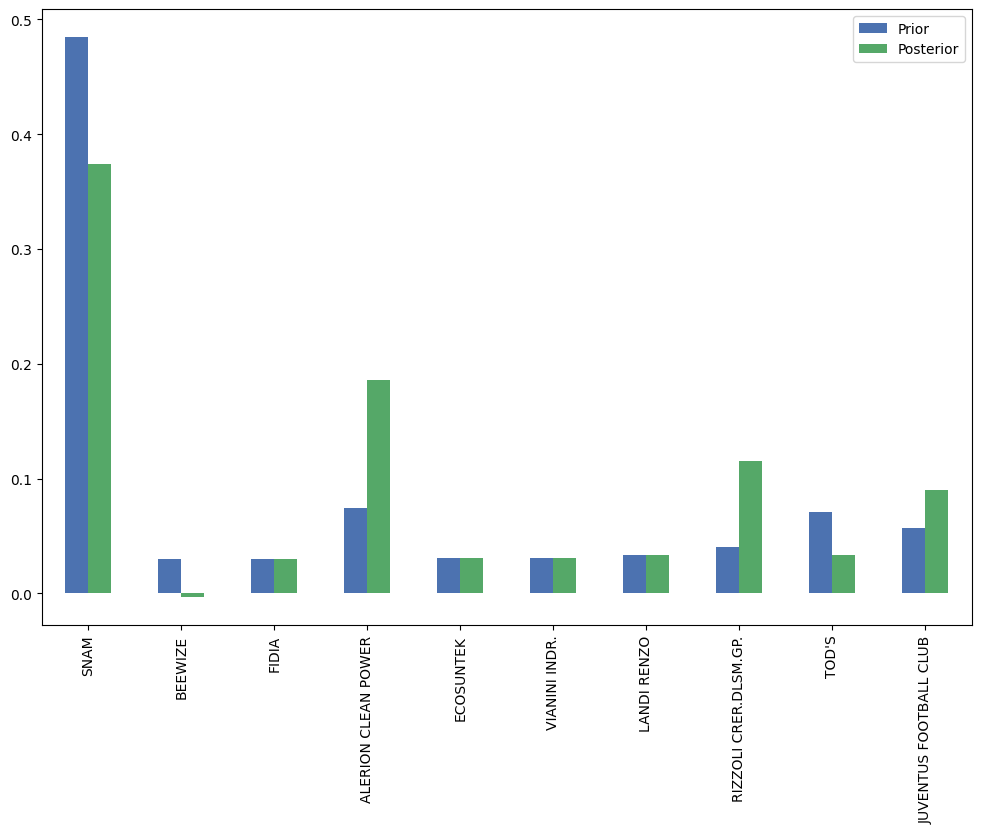

In [ ]:
rets_df.plot.bar(figsize=(12,8));

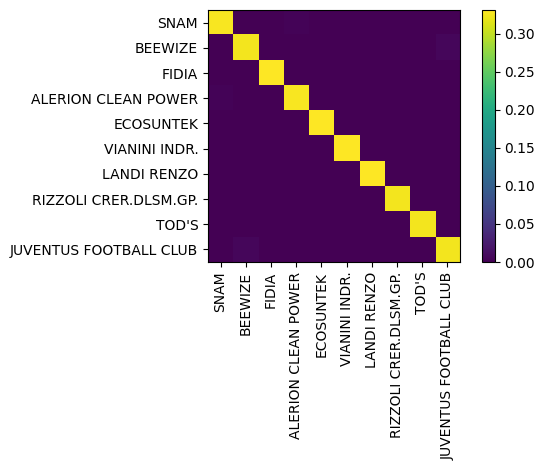

In [ ]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

### Portfolio allocation

In [ ]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S_bl, weight_bounds=(-1,1))
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe(risk_free_rate=0)
weights = ef.clean_weights()
weights

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('SNAM', 0.40571),
             ('BEEWIZE', -0.0038),
             ('FIDIA', 0.03284),
             ('ALERION CLEAN POWER', 0.20115),
             ('ECOSUNTEK', 0.03362),
             ('VIANINI INDR.', 0.03381),
             ('LANDI RENZO', 0.03642),
             ('RIZZOLI CRER.DLSM.GP.', 0.12599),
             ("TOD'S", 0.03618),
             ('JUVENTUS FOOTBALL CLUB', 0.09808)])

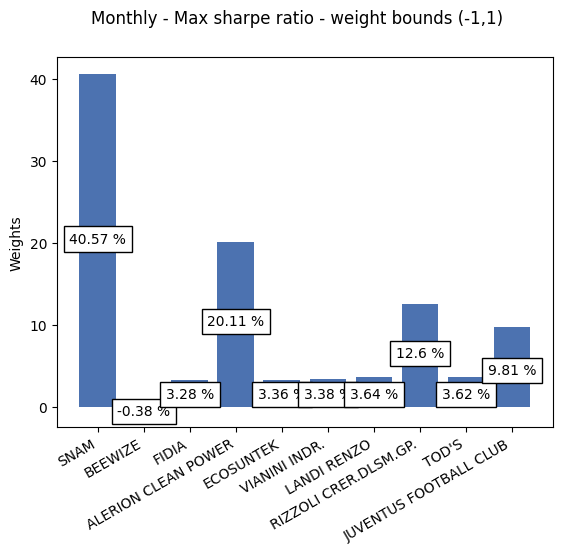

In [ ]:
plot_weights(weights, 'Monthly - Max sharpe ratio - weight bounds (-1,1)')

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


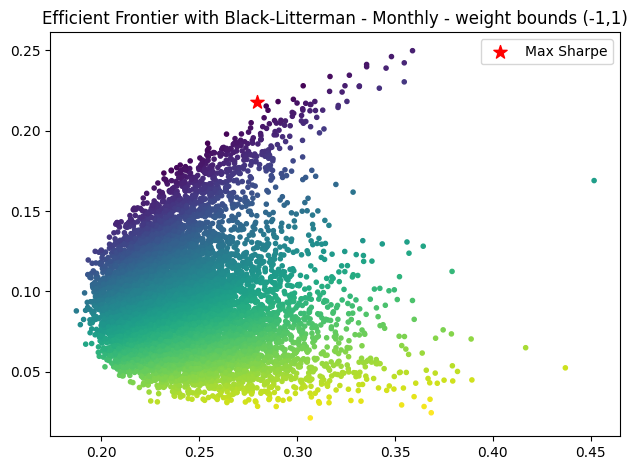

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl, weight_bounds=(-1,1))
fig, ax = pyplot.subplots()
ef_max_sharpe = ef.deepcopy()
# plot_efficient_frontier(ef, ax=ax, show_assets=False)
# Find the tangency portfolio
ef_max_sharpe.max_sharpe(risk_free_rate=0)
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")
# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title(f"Efficient Frontier with Black-Litterman - Monthly - weight bounds (-1,1)")
ax.legend()
pyplot.tight_layout()
pyplot.show()

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl, weight_bounds=(-1,1))
ef_max_sharpe = ef.deepcopy()
ef_max_sharpe.max_sharpe(risk_free_rate=0)
ret_tangent, std_tangent, sharpe_ratio_tangent = ef_max_sharpe.portfolio_performance()

print(f"Sharpe ratio                  : {sharpe_ratio_tangent}")
print(f'Return portfolio - Monthly    : {ret_tangent}')
print(f'Standard deviation - Monthly  : {std_tangent}')
print(f'Kurtosis - Monthly            : {ret_bl.kurtosis()}')
print(f'Skewness - Monthly            : {ret_bl.skew()}')

Sharpe ratio                  : 0.7796366452154172
Return portfolio - Monthly    : 0.21798029919311798
Standard deviation - Monthly  : 0.27959216710867796
Kurtosis - Monthly            : 4.2327984708668955
Skewness - Monthly            : 2.014916497891195


# Bayesian Asset Allocation

In [ ]:
portfolio_returns_daily = returns_daily.filter(selected_columns)

In [ ]:
portfolio_returns_monthly = returns_monthly.filter(selected_columns)

In [ ]:
import math
from numpy.linalg import inv

def bayesian_optimal_portfolio_daily(returns_df, l):
    mu_hat= (returns_df.mean()*252).to_numpy()
    sigma=returns_df.cov()*math.sqrt(252)
    T=returns_df.shape[0]
    mu_0=mu_hat+1*np.sqrt(np.diag(sigma))
    lambda_0=sigma*2

    mu_1 = inv(T * inv(sigma) + inv(lambda_0)) @ (T * inv(sigma) @ mu_hat + inv(lambda_0) @ mu_0)
    sigma_1 = inv(T * inv(sigma)*mu_hat + inv(lambda_0)*mu_0)

    w_bayes = (1 / l) * inv(sigma_1) @ mu_1
    w_bayes = w_bayes * 0.75 / sum(w_bayes)
    return w_bayes


def bayesian_optimal_portfolio_monthly(returns_df, l):
    mu_hat= (returns_df.mean()*12).to_numpy()
    sigma=returns_df.cov()*math.sqrt(12)
    T=returns_df.shape[0]
    mu_0=mu_hat+1*np.sqrt(np.diag(sigma))
    lambda_0=sigma*2

    mu_1 = inv(T * inv(sigma) + inv(lambda_0)) @ (T * inv(sigma) @ mu_hat + inv(lambda_0) @ mu_0)
    sigma_1 = inv(T * inv(sigma)*mu_hat + inv(lambda_0)*mu_0)

    w_bayes = (1 / l) * inv(sigma_1) @ mu_1
    w_bayes = w_bayes * 0.75 / sum(w_bayes)
    return w_bayes

bayesian_weights_daily = bayesian_optimal_portfolio_daily(returns_df=portfolio_returns_daily, l=0.9)
bayesian_weights_monthly = bayesian_optimal_portfolio_monthly(returns_df=portfolio_returns_monthly, l=0.9)

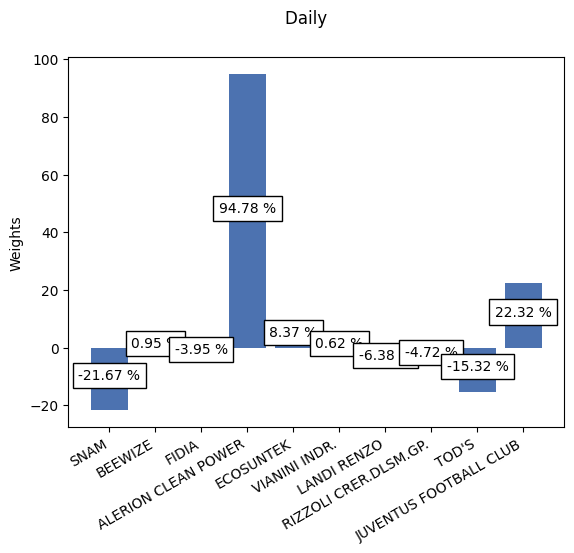

In [ ]:
plot_weights(pd.Series(bayesian_weights_daily, index=portfolio_returns_daily.columns).to_dict(), 'Daily ')

In [ ]:
risk_free_rate = 0.22
risk_free_rate_monthly = 0.16

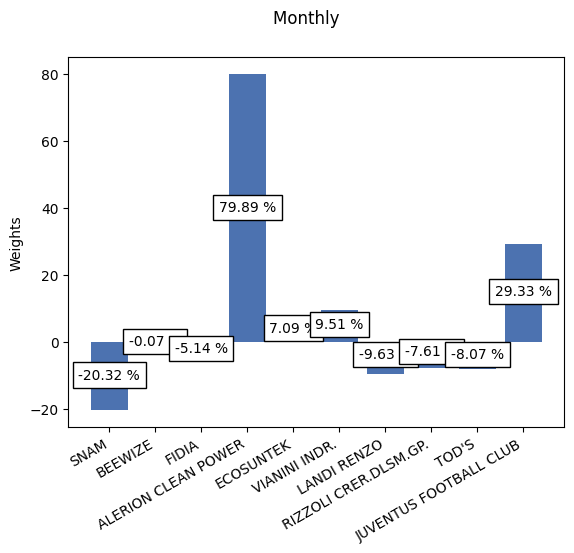

In [ ]:
plot_weights(pd.Series(bayesian_weights_monthly, index=portfolio_returns_monthly.columns).to_dict(), 'Monthly ')

In [ ]:
from scipy.stats import kurtosis, skew
# Daily
mu_hat = (portfolio_returns_daily.mean()*252).to_numpy()
sigma = portfolio_returns_daily.cov()*math.sqrt(252)
ef = EfficientFrontier(mu_hat, sigma, weight_bounds=(-1,1))
ef_max_sharpe = ef.deepcopy()
ef_max_sharpe.max_sharpe(risk_free_rate=0)
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()

print(f"Sharpe ratio: {(ret_tangent-risk_free_rate)/std_tangent}")
print(f'Return portfolio - Daily    : {ret_tangent}')
print(f'Standard deviation - Daily  : {std_tangent}')
print(f'Kurtosis - Daily            : {kurtosis(mu_hat)}')
print(f'Skewness - Daily            : {skew(mu_hat)}')

Sharpe ratio: 0.8442346652071179
Return portfolio - Daily    : 0.2797275285657463
Standard deviation - Daily  : 0.07074754333985232
Kurtosis - Daily            : 1.1437256915552405
Skewness - Daily            : 1.464908754148347


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


In [ ]:
from scipy.stats import kurtosis, skew
# Monthly
mu_hat = (portfolio_returns_monthly.mean()*12).to_numpy()
sigma = portfolio_returns_monthly.cov()*math.sqrt(12)
ef = EfficientFrontier(mu_hat, sigma, weight_bounds=(-1,1))
ef_max_sharpe = ef.deepcopy()
ef_max_sharpe.max_sharpe(risk_free_rate=0)
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
print(f"Sharpe ratio: {(ret_tangent-risk_free_rate_monthly)/std_tangent}")
print(f'Return portfolio - Monthly    : {ret_tangent}')
print(f'Standard deviation - Monthly  : {std_tangent}')
print(f'Kurtosis - Monthly            : {kurtosis(mu_hat)}')
print(f'Skewness - Monthly            : {skew(mu_hat)}')

Sharpe ratio: 0.6686180450556705
Return portfolio - Monthly    : 0.24956479251313246
Standard deviation - Monthly  : 0.1339550931588679
Kurtosis - Monthly            : -0.6098792041132146
Skewness - Monthly            : 0.9875306345669879


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
